In [85]:
#!pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121
#!pip install torchvision==0.20.1+cu121 --index-url https://download.pytorch.org/whl/cu121


In [ ]:
import torch
import torch.nn as nn
import torchvision
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

from fld.features.DINOv2FeatureExtractor import DINOv2FeatureExtractor
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.features.CLIPFeatureExtractor import CLIPFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID

In [61]:
!nvidia-smi

Sat Feb 15 08:52:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8             11W /   55W |    5876MiB /   6144MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print(torch.__version__)  


2.5.1+cu121


In [ ]:
import torch
print(torch.cuda.is_available())  #  return True if CUDA is enabled
print(torch.version.cuda)  #  show the CUDA version PyTorch was compiled with
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of your GPU (if available)


True
12.1
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [64]:
# ----------------------
# Step 4: Load Datasets (CIFAR-10)
# ----------------------

train_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=True, download=True)
train_dataset.name = "CIFAR10_train"  # Dataset needs a name to cache features

test_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=False, download=True)
test_dataset.name = "CIFAR10_test"


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# ----------------------
# Step 4: Load GENERATED Datasets (CIFAR)
# ----------------------

# Path to generated CIFAR-10 images
generated_images_path = "D:/ift6164/gen_data/stylegan-xl_data"
# Load generated CIFAR-10 dataset with stylegan
generated_dataset = ImageFolder(root=generated_images_path)
generated_dataset.name = "Generated_CIFAR10"

In [69]:
len(generated_dataset)

10000

In [ ]:

#import shutil
#shutil.rmtree("C:/Users/oumni/.cache/torch/hub", ignore_errors=True)


In [56]:
#define extractors
feature_extractor_C = CLIPFeatureExtractor()

In [57]:
feature_extractor_D = DINOv2FeatureExtractor()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to C:\Users\oumni/.cache\torch\hub\main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to C:\Users\oumni/.cache\torch\hub\checkpoints\dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:30<00:00, 11.4MB/s] 


In [70]:
## define minor transformations
def apply_gaussian_blur(img):
    """Apply a minor Gaussian Blur"""
    return transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))(img)

def apply_posterize(img):
    """Reduce color depth to simulate posterization"""
    return transforms.functional.posterize(img, bits=4)

def apply_jpeg_compression(img, quality=90):
    """Save and reload image with JPEG compression"""
    img_pil = img.convert("RGB")  # Convert to RGB mode if needed
    img_pil.save("temp.jpg", "JPEG", quality=quality)
    return Image.open("temp.jpg").convert("RGB")


## define  major transformations
def apply_color_distortion(img):
    """Randomly adjust brightness, contrast, saturation, and hue"""
    return transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)(img)

def apply_center_crop(img):
    """Crop the center region of the image"""
    return transforms.CenterCrop(size=(img.size[0] // 2, img.size[1] // 2))(img)

def apply_elastic_transform(img):
    """Apply elastic deformation (requires torchvision >= 0.11.0)"""
    return transforms.ElasticTransform(alpha=50.0)(img)

def apply_heavy_blur(img):
    """Apply a strong Gaussian blur"""
    return transforms.GaussianBlur(kernel_size=7, sigma=(5.0, 10.0))(img)

# Define the transformation dictionary
minor_transforms = {
    "Gaussian Blur": apply_gaussian_blur,
    "Posterize": apply_posterize,
    "JPG Compression": apply_jpeg_compression
}

major_transforms = {
    "Color Distortion": apply_color_distortion,
    "Center Crop": apply_center_crop,
    "Elastic Transform": apply_elastic_transform,
    "Heavy Blur": apply_heavy_blur
}


# Function to apply transformations to a dataset
def apply_transformations(dataset, transform_dict):
    transformed_datasets = {}
    for name, transform in transform_dict.items():
        #transformed_datasets[name] = [transform(img) for img in dataset]
        transformed_datasets[name] = [transform(img[0] if isinstance(img, tuple) else img) for img in dataset]
    return transformed_datasets



In [71]:
# Apply transformations to CIFAR-10 test dataset
minor_transformed_images = apply_transformations(generated_dataset, minor_transforms)
major_transformed_images = apply_transformations(generated_dataset, major_transforms)

In [ ]:
# ----------------------
# Step 5: Feature Extraction with DINOV 2 
# ----------------------
# DINOV 2 FEATURE SPACE
train_feat_D = feature_extractor_D.get_dataset_features(train_dataset)

In [ ]:
test_feat_D = feature_extractor_D.get_dataset_features(test_dataset)


In [ ]:
gen_feat_D = feature_extractor_D.get_dataset_features(generated_dataset) 

In [ ]:
# Minimal dataset wrapper for transformed images
class TransformedDataset(Dataset):
    def __init__(self, images):
        self.images = images  # List of images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # Dummy label

# Extract features for each transformed dataset
def extract_features(transformed_datasets):
    return {name: feature_extractor_D.get_dataset_features(TransformedDataset(images))
            for name, images in transformed_datasets.items()}

In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import numpy as np
import torchvision.transforms as transforms


DINO_INPUT_SIZE = 224

# Minimal dataset wrapper for transformed images
class TransformedDataset(Dataset):
    def __init__(self, images):
        self.transform = transforms.Compose([
            transforms.Resize((DINO_INPUT_SIZE, DINO_INPUT_SIZE)),  # Resize to match model
            transforms.ToTensor()  # Convert to tensor
        ])
        self.images = [self.transform(img) for img in images]  # Apply transformations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # Return (image, dummy label) tuple

# Function to extract features with batch processing and resizing
def extract_features(transformed_datasets, feature_extractor, batch_size=32):
    transformed_features = {}

    for name, images in transformed_datasets.items():
        print(f"\n[INFO] Extracting features for: {name} ({len(images)} images)")

        dataset = TransformedDataset(images)  # Convert image list to dataset
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        features_list = []
        
        for batch_idx, (img_batch, _) in enumerate(tqdm(dataloader, desc=f"Processing {name}", leave=True)):
            img_batch = img_batch.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available
            
            # Extract features for the batch
            batch_features = feature_extractor.get_feature_batch(img_batch)
            features_list.append(batch_features.cpu().numpy())

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f" - Processed {batch_idx * batch_size}/{len(images)} images for {name}")

        # Combine all batches into a single feature matrix
        transformed_features[name] = np.vstack(features_list)

    return transformed_features



In [ ]:
# Extract features for minor and major transformations with tracking
minor_feats_D = extract_features(minor_transformed_images, feature_extractor_D, batch_size=32)



[INFO] Extracting features for: Gaussian Blur (10000 images)


Processing Gaussian Blur:   0%|          | 1/313 [00:01<09:11,  1.77s/it]

 - Processed 0/10000 images for Gaussian Blur


Processing Gaussian Blur:   4%|▎         | 11/313 [00:06<02:25,  2.07it/s]

 - Processed 320/10000 images for Gaussian Blur


Processing Gaussian Blur:   7%|▋         | 21/313 [00:10<01:41,  2.88it/s]

 - Processed 640/10000 images for Gaussian Blur


Processing Gaussian Blur:  10%|▉         | 31/313 [00:13<01:34,  2.99it/s]

 - Processed 960/10000 images for Gaussian Blur


Processing Gaussian Blur:  13%|█▎        | 41/313 [00:17<01:28,  3.07it/s]

 - Processed 1280/10000 images for Gaussian Blur


Processing Gaussian Blur:  16%|█▋        | 51/313 [00:20<01:24,  3.09it/s]

 - Processed 1600/10000 images for Gaussian Blur


Processing Gaussian Blur:  19%|█▉        | 61/313 [00:23<01:21,  3.08it/s]

 - Processed 1920/10000 images for Gaussian Blur


Processing Gaussian Blur:  23%|██▎       | 71/313 [00:26<01:19,  3.03it/s]

 - Processed 2240/10000 images for Gaussian Blur


Processing Gaussian Blur:  26%|██▌       | 81/313 [00:30<01:16,  3.03it/s]

 - Processed 2560/10000 images for Gaussian Blur


Processing Gaussian Blur:  29%|██▉       | 91/313 [00:33<01:13,  3.03it/s]

 - Processed 2880/10000 images for Gaussian Blur


Processing Gaussian Blur:  32%|███▏      | 101/313 [00:36<01:10,  2.99it/s]

 - Processed 3200/10000 images for Gaussian Blur


Processing Gaussian Blur:  35%|███▌      | 111/313 [00:40<01:10,  2.87it/s]

 - Processed 3520/10000 images for Gaussian Blur


Processing Gaussian Blur:  39%|███▊      | 121/313 [00:43<01:07,  2.86it/s]

 - Processed 3840/10000 images for Gaussian Blur


Processing Gaussian Blur:  42%|████▏     | 131/313 [00:47<01:02,  2.89it/s]

 - Processed 4160/10000 images for Gaussian Blur


Processing Gaussian Blur:  45%|████▌     | 141/313 [00:50<00:57,  2.98it/s]

 - Processed 4480/10000 images for Gaussian Blur


Processing Gaussian Blur:  48%|████▊     | 151/313 [00:54<00:53,  3.01it/s]

 - Processed 4800/10000 images for Gaussian Blur


Processing Gaussian Blur:  51%|█████▏    | 161/313 [00:57<00:50,  3.01it/s]

 - Processed 5120/10000 images for Gaussian Blur


Processing Gaussian Blur:  55%|█████▍    | 171/313 [01:00<00:46,  3.05it/s]

 - Processed 5440/10000 images for Gaussian Blur


Processing Gaussian Blur:  58%|█████▊    | 181/313 [01:03<00:43,  3.04it/s]

 - Processed 5760/10000 images for Gaussian Blur


Processing Gaussian Blur:  61%|██████    | 191/313 [01:07<00:40,  3.04it/s]

 - Processed 6080/10000 images for Gaussian Blur


Processing Gaussian Blur:  64%|██████▍   | 201/313 [01:10<00:36,  3.04it/s]

 - Processed 6400/10000 images for Gaussian Blur


Processing Gaussian Blur:  67%|██████▋   | 211/313 [01:13<00:33,  3.04it/s]

 - Processed 6720/10000 images for Gaussian Blur


Processing Gaussian Blur:  71%|███████   | 221/313 [01:17<00:30,  3.04it/s]

 - Processed 7040/10000 images for Gaussian Blur


Processing Gaussian Blur:  74%|███████▍  | 231/313 [01:20<00:27,  3.02it/s]

 - Processed 7360/10000 images for Gaussian Blur


Processing Gaussian Blur:  77%|███████▋  | 241/313 [01:23<00:23,  3.03it/s]

 - Processed 7680/10000 images for Gaussian Blur


Processing Gaussian Blur:  80%|████████  | 251/313 [01:27<00:20,  3.01it/s]

 - Processed 8000/10000 images for Gaussian Blur


Processing Gaussian Blur:  83%|████████▎ | 261/313 [01:30<00:20,  2.51it/s]

 - Processed 8320/10000 images for Gaussian Blur


Processing Gaussian Blur:  87%|████████▋ | 271/313 [01:34<00:16,  2.57it/s]

 - Processed 8640/10000 images for Gaussian Blur


Processing Gaussian Blur:  90%|████████▉ | 281/313 [01:38<00:10,  2.93it/s]

 - Processed 8960/10000 images for Gaussian Blur


Processing Gaussian Blur:  93%|█████████▎| 291/313 [01:41<00:07,  3.02it/s]

 - Processed 9280/10000 images for Gaussian Blur


Processing Gaussian Blur:  96%|█████████▌| 301/313 [01:45<00:04,  2.53it/s]

 - Processed 9600/10000 images for Gaussian Blur


Processing Gaussian Blur:  99%|█████████▉| 311/313 [01:49<00:00,  2.42it/s]

 - Processed 9920/10000 images for Gaussian Blur


Processing Gaussian Blur: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]



[INFO] Extracting features for: Posterize (10000 images)


Processing Posterize:   0%|          | 1/313 [00:00<04:02,  1.29it/s]

 - Processed 0/10000 images for Posterize


Processing Posterize:   4%|▎         | 11/313 [00:05<02:05,  2.40it/s]

 - Processed 320/10000 images for Posterize


Processing Posterize:   7%|▋         | 21/313 [00:08<01:37,  2.99it/s]

 - Processed 640/10000 images for Posterize


Processing Posterize:  10%|▉         | 31/313 [00:11<01:28,  3.20it/s]

 - Processed 960/10000 images for Posterize


Processing Posterize:  13%|█▎        | 41/313 [00:15<01:21,  3.32it/s]

 - Processed 1280/10000 images for Posterize


Processing Posterize:  16%|█▋        | 51/313 [00:18<01:19,  3.30it/s]

 - Processed 1600/10000 images for Posterize


Processing Posterize:  19%|█▉        | 61/313 [00:21<01:17,  3.26it/s]

 - Processed 1920/10000 images for Posterize


Processing Posterize:  23%|██▎       | 71/313 [00:24<01:14,  3.23it/s]

 - Processed 2240/10000 images for Posterize


Processing Posterize:  26%|██▌       | 81/313 [00:27<01:13,  3.14it/s]

 - Processed 2560/10000 images for Posterize


Processing Posterize:  29%|██▉       | 91/313 [00:30<01:11,  3.11it/s]

 - Processed 2880/10000 images for Posterize


Processing Posterize:  32%|███▏      | 101/313 [00:33<01:09,  3.04it/s]

 - Processed 3200/10000 images for Posterize


Processing Posterize:  35%|███▌      | 111/313 [00:37<01:06,  3.02it/s]

 - Processed 3520/10000 images for Posterize


Processing Posterize:  39%|███▊      | 121/313 [00:40<01:04,  2.98it/s]

 - Processed 3840/10000 images for Posterize


Processing Posterize:  42%|████▏     | 131/313 [00:43<01:01,  2.96it/s]

 - Processed 4160/10000 images for Posterize


Processing Posterize:  45%|████▌     | 141/313 [00:47<00:58,  2.95it/s]

 - Processed 4480/10000 images for Posterize


Processing Posterize:  48%|████▊     | 151/313 [00:50<00:56,  2.87it/s]

 - Processed 4800/10000 images for Posterize


Processing Posterize:  51%|█████▏    | 161/313 [00:54<00:53,  2.84it/s]

 - Processed 5120/10000 images for Posterize


Processing Posterize:  55%|█████▍    | 171/313 [00:57<00:48,  2.94it/s]

 - Processed 5440/10000 images for Posterize


Processing Posterize:  58%|█████▊    | 181/313 [01:01<00:45,  2.88it/s]

 - Processed 5760/10000 images for Posterize


Processing Posterize:  61%|██████    | 191/313 [01:04<00:42,  2.89it/s]

 - Processed 6080/10000 images for Posterize


Processing Posterize:  64%|██████▍   | 201/313 [01:08<00:39,  2.84it/s]

 - Processed 6400/10000 images for Posterize


Processing Posterize:  67%|██████▋   | 211/313 [01:11<00:35,  2.85it/s]

 - Processed 6720/10000 images for Posterize


Processing Posterize:  71%|███████   | 221/313 [01:15<00:32,  2.84it/s]

 - Processed 7040/10000 images for Posterize


Processing Posterize:  74%|███████▍  | 231/313 [01:18<00:28,  2.83it/s]

 - Processed 7360/10000 images for Posterize


Processing Posterize:  77%|███████▋  | 241/313 [01:22<00:25,  2.84it/s]

 - Processed 7680/10000 images for Posterize


Processing Posterize:  80%|████████  | 251/313 [01:25<00:21,  2.84it/s]

 - Processed 8000/10000 images for Posterize


Processing Posterize:  83%|████████▎ | 261/313 [01:29<00:18,  2.84it/s]

 - Processed 8320/10000 images for Posterize


Processing Posterize:  87%|████████▋ | 271/313 [01:32<00:14,  2.85it/s]

 - Processed 8640/10000 images for Posterize


Processing Posterize:  90%|████████▉ | 281/313 [01:36<00:11,  2.86it/s]

 - Processed 8960/10000 images for Posterize


Processing Posterize:  93%|█████████▎| 291/313 [01:39<00:07,  2.82it/s]

 - Processed 9280/10000 images for Posterize


Processing Posterize:  96%|█████████▌| 301/313 [01:43<00:04,  2.82it/s]

 - Processed 9600/10000 images for Posterize


Processing Posterize:  99%|█████████▉| 311/313 [01:46<00:00,  2.82it/s]

 - Processed 9920/10000 images for Posterize


Processing Posterize: 100%|██████████| 313/313 [01:47<00:00,  2.91it/s]



[INFO] Extracting features for: JPG Compression (10000 images)


Processing JPG Compression:   0%|          | 1/313 [00:00<04:31,  1.15it/s]

 - Processed 0/10000 images for JPG Compression


Processing JPG Compression:   4%|▎         | 11/313 [00:05<02:22,  2.12it/s]

 - Processed 320/10000 images for JPG Compression


Processing JPG Compression:   7%|▋         | 21/313 [00:09<01:37,  2.98it/s]

 - Processed 640/10000 images for JPG Compression


Processing JPG Compression:  10%|▉         | 31/313 [00:12<01:28,  3.18it/s]

 - Processed 960/10000 images for JPG Compression


Processing JPG Compression:  13%|█▎        | 41/313 [00:15<01:27,  3.10it/s]

 - Processed 1280/10000 images for JPG Compression


Processing JPG Compression:  16%|█▋        | 51/313 [00:19<01:29,  2.91it/s]

 - Processed 1600/10000 images for JPG Compression


Processing JPG Compression:  19%|█▉        | 61/313 [00:22<01:29,  2.82it/s]

 - Processed 1920/10000 images for JPG Compression


Processing JPG Compression:  23%|██▎       | 71/313 [00:26<01:29,  2.70it/s]

 - Processed 2240/10000 images for JPG Compression


Processing JPG Compression:  26%|██▌       | 81/313 [00:30<01:27,  2.66it/s]

 - Processed 2560/10000 images for JPG Compression


Processing JPG Compression:  29%|██▉       | 91/313 [00:33<01:23,  2.66it/s]

 - Processed 2880/10000 images for JPG Compression


Processing JPG Compression:  32%|███▏      | 101/313 [00:37<01:19,  2.67it/s]

 - Processed 3200/10000 images for JPG Compression


Processing JPG Compression:  35%|███▌      | 111/313 [00:41<01:15,  2.67it/s]

 - Processed 3520/10000 images for JPG Compression


Processing JPG Compression:  39%|███▊      | 121/313 [00:44<01:12,  2.66it/s]

 - Processed 3840/10000 images for JPG Compression


Processing JPG Compression:  42%|████▏     | 131/313 [00:48<01:05,  2.76it/s]

 - Processed 4160/10000 images for JPG Compression


Processing JPG Compression:  45%|████▌     | 141/313 [00:52<01:03,  2.71it/s]

 - Processed 4480/10000 images for JPG Compression


Processing JPG Compression:  48%|████▊     | 151/313 [00:55<01:00,  2.69it/s]

 - Processed 4800/10000 images for JPG Compression


Processing JPG Compression:  51%|█████▏    | 161/313 [00:59<00:56,  2.68it/s]

 - Processed 5120/10000 images for JPG Compression


Processing JPG Compression:  55%|█████▍    | 171/313 [01:03<00:54,  2.59it/s]

 - Processed 5440/10000 images for JPG Compression


Processing JPG Compression:  58%|█████▊    | 181/313 [01:07<00:51,  2.58it/s]

 - Processed 5760/10000 images for JPG Compression


Processing JPG Compression:  61%|██████    | 191/313 [01:11<00:47,  2.58it/s]

 - Processed 6080/10000 images for JPG Compression


Processing JPG Compression:  64%|██████▍   | 201/313 [01:15<00:43,  2.58it/s]

 - Processed 6400/10000 images for JPG Compression


Processing JPG Compression:  67%|██████▋   | 211/313 [01:19<00:39,  2.58it/s]

 - Processed 6720/10000 images for JPG Compression


Processing JPG Compression:  71%|███████   | 221/313 [01:22<00:35,  2.58it/s]

 - Processed 7040/10000 images for JPG Compression


Processing JPG Compression:  74%|███████▍  | 231/313 [01:26<00:31,  2.58it/s]

 - Processed 7360/10000 images for JPG Compression


Processing JPG Compression:  77%|███████▋  | 241/313 [01:30<00:27,  2.58it/s]

 - Processed 7680/10000 images for JPG Compression


Processing JPG Compression:  80%|████████  | 251/313 [01:34<00:24,  2.56it/s]

 - Processed 8000/10000 images for JPG Compression


Processing JPG Compression:  83%|████████▎ | 261/313 [01:38<00:20,  2.56it/s]

 - Processed 8320/10000 images for JPG Compression


Processing JPG Compression:  87%|████████▋ | 271/313 [01:42<00:16,  2.58it/s]

 - Processed 8640/10000 images for JPG Compression


Processing JPG Compression:  90%|████████▉ | 281/313 [01:46<00:12,  2.57it/s]

 - Processed 8960/10000 images for JPG Compression


Processing JPG Compression:  93%|█████████▎| 291/313 [01:50<00:08,  2.58it/s]

 - Processed 9280/10000 images for JPG Compression


Processing JPG Compression:  96%|█████████▌| 301/313 [01:53<00:04,  2.58it/s]

 - Processed 9600/10000 images for JPG Compression


Processing JPG Compression:  99%|█████████▉| 311/313 [01:57<00:00,  2.58it/s]

 - Processed 9920/10000 images for JPG Compression


Processing JPG Compression: 100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


In [ ]:
major_feats_D = extract_features(major_transformed_images, feature_extractor_D, batch_size=32)


[INFO] Extracting features for: Color Distortion (10000 images)


Processing Color Distortion:   0%|          | 1/313 [00:00<03:29,  1.49it/s]

 - Processed 0/10000 images for Color Distortion


Processing Color Distortion:   4%|▎         | 11/313 [00:04<01:42,  2.95it/s]

 - Processed 320/10000 images for Color Distortion


Processing Color Distortion:   7%|▋         | 21/313 [00:07<01:32,  3.16it/s]

 - Processed 640/10000 images for Color Distortion


Processing Color Distortion:  10%|▉         | 31/313 [00:10<01:27,  3.23it/s]

 - Processed 960/10000 images for Color Distortion


Processing Color Distortion:  13%|█▎        | 41/313 [00:13<01:22,  3.31it/s]

 - Processed 1280/10000 images for Color Distortion


Processing Color Distortion:  16%|█▋        | 51/313 [00:16<01:19,  3.30it/s]

 - Processed 1600/10000 images for Color Distortion


Processing Color Distortion:  19%|█▉        | 61/313 [00:19<01:16,  3.30it/s]

 - Processed 1920/10000 images for Color Distortion


Processing Color Distortion:  23%|██▎       | 71/313 [00:22<01:13,  3.28it/s]

 - Processed 2240/10000 images for Color Distortion


Processing Color Distortion:  26%|██▌       | 81/313 [00:25<01:10,  3.27it/s]

 - Processed 2560/10000 images for Color Distortion


Processing Color Distortion:  29%|██▉       | 91/313 [00:28<01:07,  3.27it/s]

 - Processed 2880/10000 images for Color Distortion


Processing Color Distortion:  32%|███▏      | 101/313 [00:32<01:04,  3.29it/s]

 - Processed 3200/10000 images for Color Distortion


Processing Color Distortion:  35%|███▌      | 111/313 [00:35<01:02,  3.21it/s]

 - Processed 3520/10000 images for Color Distortion


Processing Color Distortion:  39%|███▊      | 121/313 [00:38<00:59,  3.23it/s]

 - Processed 3840/10000 images for Color Distortion


Processing Color Distortion:  42%|████▏     | 131/313 [00:41<00:57,  3.19it/s]

 - Processed 4160/10000 images for Color Distortion


Processing Color Distortion:  45%|████▌     | 141/313 [00:44<00:54,  3.14it/s]

 - Processed 4480/10000 images for Color Distortion


Processing Color Distortion:  48%|████▊     | 151/313 [00:47<00:51,  3.15it/s]

 - Processed 4800/10000 images for Color Distortion


Processing Color Distortion:  51%|█████▏    | 161/313 [00:50<00:49,  3.10it/s]

 - Processed 5120/10000 images for Color Distortion


Processing Color Distortion:  55%|█████▍    | 171/313 [00:54<00:47,  3.01it/s]

 - Processed 5440/10000 images for Color Distortion


Processing Color Distortion:  58%|█████▊    | 181/313 [00:57<00:45,  2.91it/s]

 - Processed 5760/10000 images for Color Distortion


Processing Color Distortion:  61%|██████    | 191/313 [01:02<00:56,  2.16it/s]

 - Processed 6080/10000 images for Color Distortion


Processing Color Distortion:  64%|██████▍   | 201/313 [01:06<00:47,  2.37it/s]

 - Processed 6400/10000 images for Color Distortion


Processing Color Distortion:  67%|██████▋   | 211/313 [01:11<00:47,  2.16it/s]

 - Processed 6720/10000 images for Color Distortion


Processing Color Distortion:  71%|███████   | 221/313 [01:16<00:44,  2.07it/s]

 - Processed 7040/10000 images for Color Distortion


Processing Color Distortion:  74%|███████▍  | 231/313 [01:21<00:42,  1.91it/s]

 - Processed 7360/10000 images for Color Distortion


Processing Color Distortion:  77%|███████▋  | 241/313 [01:25<00:25,  2.82it/s]

 - Processed 7680/10000 images for Color Distortion


Processing Color Distortion:  80%|████████  | 251/313 [01:28<00:20,  3.02it/s]

 - Processed 8000/10000 images for Color Distortion


Processing Color Distortion:  83%|████████▎ | 261/313 [01:31<00:17,  2.98it/s]

 - Processed 8320/10000 images for Color Distortion


Processing Color Distortion:  87%|████████▋ | 271/313 [01:35<00:14,  2.96it/s]

 - Processed 8640/10000 images for Color Distortion


Processing Color Distortion:  90%|████████▉ | 281/313 [01:38<00:11,  2.90it/s]

 - Processed 8960/10000 images for Color Distortion


Processing Color Distortion:  93%|█████████▎| 291/313 [01:42<00:07,  2.90it/s]

 - Processed 9280/10000 images for Color Distortion


Processing Color Distortion:  96%|█████████▌| 301/313 [01:45<00:04,  2.78it/s]

 - Processed 9600/10000 images for Color Distortion


Processing Color Distortion:  99%|█████████▉| 311/313 [01:49<00:00,  2.87it/s]

 - Processed 9920/10000 images for Color Distortion


Processing Color Distortion: 100%|██████████| 313/313 [01:49<00:00,  2.85it/s]



[INFO] Extracting features for: Center Crop (10000 images)


Processing Center Crop:   0%|          | 1/313 [00:00<04:14,  1.23it/s]

 - Processed 0/10000 images for Center Crop


Processing Center Crop:   4%|▎         | 11/313 [00:05<02:01,  2.49it/s]

 - Processed 320/10000 images for Center Crop


Processing Center Crop:   7%|▋         | 21/313 [00:08<01:35,  3.05it/s]

 - Processed 640/10000 images for Center Crop


Processing Center Crop:  10%|▉         | 31/313 [00:12<01:40,  2.81it/s]

 - Processed 960/10000 images for Center Crop


Processing Center Crop:  13%|█▎        | 41/313 [00:15<01:28,  3.08it/s]

 - Processed 1280/10000 images for Center Crop


Processing Center Crop:  16%|█▋        | 51/313 [00:18<01:34,  2.78it/s]

 - Processed 1600/10000 images for Center Crop


Processing Center Crop:  19%|█▉        | 61/313 [00:22<01:24,  2.97it/s]

 - Processed 1920/10000 images for Center Crop


Processing Center Crop:  23%|██▎       | 71/313 [00:25<01:26,  2.81it/s]

 - Processed 2240/10000 images for Center Crop


Processing Center Crop:  26%|██▌       | 81/313 [00:29<01:21,  2.84it/s]

 - Processed 2560/10000 images for Center Crop


Processing Center Crop:  29%|██▉       | 91/313 [00:32<01:18,  2.81it/s]

 - Processed 2880/10000 images for Center Crop


Processing Center Crop:  32%|███▏      | 101/313 [00:36<01:14,  2.84it/s]

 - Processed 3200/10000 images for Center Crop


Processing Center Crop:  35%|███▌      | 111/313 [00:40<01:11,  2.83it/s]

 - Processed 3520/10000 images for Center Crop


Processing Center Crop:  39%|███▊      | 121/313 [00:43<01:09,  2.75it/s]

 - Processed 3840/10000 images for Center Crop


Processing Center Crop:  42%|████▏     | 131/313 [00:47<01:07,  2.69it/s]

 - Processed 4160/10000 images for Center Crop


Processing Center Crop:  45%|████▌     | 141/313 [00:51<01:05,  2.64it/s]

 - Processed 4480/10000 images for Center Crop


Processing Center Crop:  48%|████▊     | 151/313 [00:55<01:04,  2.50it/s]

 - Processed 4800/10000 images for Center Crop


Processing Center Crop:  51%|█████▏    | 161/313 [00:59<00:59,  2.54it/s]

 - Processed 5120/10000 images for Center Crop


Processing Center Crop:  55%|█████▍    | 171/313 [01:02<00:53,  2.63it/s]

 - Processed 5440/10000 images for Center Crop


Processing Center Crop:  58%|█████▊    | 181/313 [01:06<00:49,  2.67it/s]

 - Processed 5760/10000 images for Center Crop


Processing Center Crop:  61%|██████    | 191/313 [01:10<00:43,  2.83it/s]

 - Processed 6080/10000 images for Center Crop


Processing Center Crop:  64%|██████▍   | 201/313 [01:13<00:40,  2.78it/s]

 - Processed 6400/10000 images for Center Crop


Processing Center Crop:  67%|██████▋   | 211/313 [01:17<00:35,  2.85it/s]

 - Processed 6720/10000 images for Center Crop


Processing Center Crop:  71%|███████   | 221/313 [01:20<00:32,  2.81it/s]

 - Processed 7040/10000 images for Center Crop


Processing Center Crop:  74%|███████▍  | 231/313 [01:24<00:30,  2.72it/s]

 - Processed 7360/10000 images for Center Crop


Processing Center Crop:  77%|███████▋  | 241/313 [01:28<00:26,  2.76it/s]

 - Processed 7680/10000 images for Center Crop


Processing Center Crop:  80%|████████  | 251/313 [01:32<00:22,  2.70it/s]

 - Processed 8000/10000 images for Center Crop


Processing Center Crop:  83%|████████▎ | 261/313 [01:35<00:18,  2.81it/s]

 - Processed 8320/10000 images for Center Crop


Processing Center Crop:  87%|████████▋ | 271/313 [01:39<00:14,  2.90it/s]

 - Processed 8640/10000 images for Center Crop


Processing Center Crop:  90%|████████▉ | 281/313 [01:42<00:11,  2.85it/s]

 - Processed 8960/10000 images for Center Crop


Processing Center Crop:  93%|█████████▎| 291/313 [01:46<00:08,  2.59it/s]

 - Processed 9280/10000 images for Center Crop


Processing Center Crop:  96%|█████████▌| 301/313 [01:50<00:04,  2.78it/s]

 - Processed 9600/10000 images for Center Crop


Processing Center Crop:  99%|█████████▉| 311/313 [01:53<00:00,  2.87it/s]

 - Processed 9920/10000 images for Center Crop


Processing Center Crop: 100%|██████████| 313/313 [01:54<00:00,  2.74it/s]



[INFO] Extracting features for: Elastic Transform (10000 images)


Processing Elastic Transform:   0%|          | 1/313 [00:00<03:54,  1.33it/s]

 - Processed 0/10000 images for Elastic Transform


Processing Elastic Transform:   4%|▎         | 11/313 [00:06<02:39,  1.89it/s]

 - Processed 320/10000 images for Elastic Transform


Processing Elastic Transform:   7%|▋         | 21/313 [00:10<02:01,  2.41it/s]

 - Processed 640/10000 images for Elastic Transform


Processing Elastic Transform:  10%|▉         | 31/313 [00:14<01:51,  2.52it/s]

 - Processed 960/10000 images for Elastic Transform


Processing Elastic Transform:  13%|█▎        | 41/313 [00:17<01:33,  2.91it/s]

 - Processed 1280/10000 images for Elastic Transform


Processing Elastic Transform:  16%|█▋        | 51/313 [00:21<01:27,  2.99it/s]

 - Processed 1600/10000 images for Elastic Transform


Processing Elastic Transform:  19%|█▉        | 61/313 [00:24<01:22,  3.07it/s]

 - Processed 1920/10000 images for Elastic Transform


Processing Elastic Transform:  23%|██▎       | 71/313 [00:27<01:20,  3.00it/s]

 - Processed 2240/10000 images for Elastic Transform


Processing Elastic Transform:  26%|██▌       | 81/313 [00:31<01:20,  2.88it/s]

 - Processed 2560/10000 images for Elastic Transform


Processing Elastic Transform:  29%|██▉       | 91/313 [00:34<01:14,  2.98it/s]

 - Processed 2880/10000 images for Elastic Transform


Processing Elastic Transform:  32%|███▏      | 101/313 [00:38<01:12,  2.93it/s]

 - Processed 3200/10000 images for Elastic Transform


Processing Elastic Transform:  35%|███▌      | 111/313 [00:41<01:10,  2.88it/s]

 - Processed 3520/10000 images for Elastic Transform


Processing Elastic Transform:  39%|███▊      | 121/313 [00:45<01:09,  2.76it/s]

 - Processed 3840/10000 images for Elastic Transform


Processing Elastic Transform:  42%|████▏     | 131/313 [00:49<01:05,  2.76it/s]

 - Processed 4160/10000 images for Elastic Transform


Processing Elastic Transform:  45%|████▌     | 141/313 [00:52<01:02,  2.77it/s]

 - Processed 4480/10000 images for Elastic Transform


Processing Elastic Transform:  48%|████▊     | 151/313 [00:56<00:56,  2.84it/s]

 - Processed 4800/10000 images for Elastic Transform


Processing Elastic Transform:  51%|█████▏    | 161/313 [00:59<00:57,  2.65it/s]

 - Processed 5120/10000 images for Elastic Transform


Processing Elastic Transform:  55%|█████▍    | 171/313 [01:03<00:49,  2.89it/s]

 - Processed 5440/10000 images for Elastic Transform


Processing Elastic Transform:  58%|█████▊    | 181/313 [01:07<00:52,  2.53it/s]

 - Processed 5760/10000 images for Elastic Transform


Processing Elastic Transform:  61%|██████    | 191/313 [01:11<00:44,  2.76it/s]

 - Processed 6080/10000 images for Elastic Transform


Processing Elastic Transform:  64%|██████▍   | 201/313 [01:14<00:40,  2.75it/s]

 - Processed 6400/10000 images for Elastic Transform


Processing Elastic Transform:  67%|██████▋   | 211/313 [01:18<00:39,  2.61it/s]

 - Processed 6720/10000 images for Elastic Transform


Processing Elastic Transform:  71%|███████   | 221/313 [01:22<00:32,  2.81it/s]

 - Processed 7040/10000 images for Elastic Transform


Processing Elastic Transform:  74%|███████▍  | 231/313 [01:25<00:28,  2.85it/s]

 - Processed 7360/10000 images for Elastic Transform


Processing Elastic Transform:  77%|███████▋  | 241/313 [01:29<00:25,  2.86it/s]

 - Processed 7680/10000 images for Elastic Transform


Processing Elastic Transform:  80%|████████  | 251/313 [01:32<00:22,  2.76it/s]

 - Processed 8000/10000 images for Elastic Transform


Processing Elastic Transform:  83%|████████▎ | 261/313 [01:36<00:18,  2.76it/s]

 - Processed 8320/10000 images for Elastic Transform


Processing Elastic Transform:  87%|████████▋ | 271/313 [01:40<00:15,  2.72it/s]

 - Processed 8640/10000 images for Elastic Transform


Processing Elastic Transform:  90%|████████▉ | 281/313 [01:43<00:11,  2.69it/s]

 - Processed 8960/10000 images for Elastic Transform


Processing Elastic Transform:  93%|█████████▎| 291/313 [01:47<00:07,  2.80it/s]

 - Processed 9280/10000 images for Elastic Transform


Processing Elastic Transform:  96%|█████████▌| 301/313 [01:51<00:04,  2.72it/s]

 - Processed 9600/10000 images for Elastic Transform


Processing Elastic Transform:  99%|█████████▉| 311/313 [01:54<00:00,  2.73it/s]

 - Processed 9920/10000 images for Elastic Transform


Processing Elastic Transform: 100%|██████████| 313/313 [01:55<00:00,  2.72it/s]



[INFO] Extracting features for: Heavy Blur (10000 images)


Processing Heavy Blur:   0%|          | 1/313 [00:00<04:44,  1.10it/s]

 - Processed 0/10000 images for Heavy Blur


Processing Heavy Blur:   4%|▎         | 11/313 [00:06<02:11,  2.30it/s]

 - Processed 320/10000 images for Heavy Blur


Processing Heavy Blur:   7%|▋         | 21/313 [00:09<01:41,  2.87it/s]

 - Processed 640/10000 images for Heavy Blur


Processing Heavy Blur:  10%|▉         | 31/313 [00:12<01:33,  3.00it/s]

 - Processed 960/10000 images for Heavy Blur


Processing Heavy Blur:  13%|█▎        | 41/313 [00:16<01:31,  2.98it/s]

 - Processed 1280/10000 images for Heavy Blur


Processing Heavy Blur:  16%|█▋        | 51/313 [00:19<01:31,  2.87it/s]

 - Processed 1600/10000 images for Heavy Blur


Processing Heavy Blur:  19%|█▉        | 61/313 [00:23<01:30,  2.77it/s]

 - Processed 1920/10000 images for Heavy Blur


Processing Heavy Blur:  23%|██▎       | 71/313 [00:26<01:31,  2.65it/s]

 - Processed 2240/10000 images for Heavy Blur


Processing Heavy Blur:  26%|██▌       | 81/313 [00:30<01:25,  2.72it/s]

 - Processed 2560/10000 images for Heavy Blur


Processing Heavy Blur:  29%|██▉       | 91/313 [00:34<01:26,  2.58it/s]

 - Processed 2880/10000 images for Heavy Blur


Processing Heavy Blur:  32%|███▏      | 101/313 [00:38<01:20,  2.63it/s]

 - Processed 3200/10000 images for Heavy Blur


Processing Heavy Blur:  35%|███▌      | 111/313 [00:42<01:17,  2.62it/s]

 - Processed 3520/10000 images for Heavy Blur


Processing Heavy Blur:  39%|███▊      | 121/313 [00:46<01:15,  2.53it/s]

 - Processed 3840/10000 images for Heavy Blur


Processing Heavy Blur:  42%|████▏     | 131/313 [00:50<01:11,  2.53it/s]

 - Processed 4160/10000 images for Heavy Blur


Processing Heavy Blur:  45%|████▌     | 141/313 [00:53<01:07,  2.53it/s]

 - Processed 4480/10000 images for Heavy Blur


Processing Heavy Blur:  48%|████▊     | 151/313 [00:57<01:00,  2.68it/s]

 - Processed 4800/10000 images for Heavy Blur


Processing Heavy Blur:  51%|█████▏    | 161/313 [01:01<00:55,  2.74it/s]

 - Processed 5120/10000 images for Heavy Blur


Processing Heavy Blur:  55%|█████▍    | 171/313 [01:05<00:51,  2.74it/s]

 - Processed 5440/10000 images for Heavy Blur


Processing Heavy Blur:  58%|█████▊    | 181/313 [01:08<00:48,  2.74it/s]

 - Processed 5760/10000 images for Heavy Blur


Processing Heavy Blur:  61%|██████    | 191/313 [01:12<00:44,  2.74it/s]

 - Processed 6080/10000 images for Heavy Blur


Processing Heavy Blur:  64%|██████▍   | 201/313 [01:15<00:40,  2.74it/s]

 - Processed 6400/10000 images for Heavy Blur


Processing Heavy Blur:  67%|██████▋   | 211/313 [01:19<00:37,  2.74it/s]

 - Processed 6720/10000 images for Heavy Blur


Processing Heavy Blur:  71%|███████   | 221/313 [01:23<00:34,  2.69it/s]

 - Processed 7040/10000 images for Heavy Blur


Processing Heavy Blur:  74%|███████▍  | 231/313 [01:26<00:29,  2.76it/s]

 - Processed 7360/10000 images for Heavy Blur


Processing Heavy Blur:  77%|███████▋  | 241/313 [01:30<00:26,  2.72it/s]

 - Processed 7680/10000 images for Heavy Blur


Processing Heavy Blur:  80%|████████  | 251/313 [01:34<00:22,  2.71it/s]

 - Processed 8000/10000 images for Heavy Blur


Processing Heavy Blur:  83%|████████▎ | 261/313 [01:38<00:19,  2.72it/s]

 - Processed 8320/10000 images for Heavy Blur


Processing Heavy Blur:  87%|████████▋ | 271/313 [01:41<00:15,  2.66it/s]

 - Processed 8640/10000 images for Heavy Blur


Processing Heavy Blur:  90%|████████▉ | 281/313 [01:45<00:12,  2.66it/s]

 - Processed 8960/10000 images for Heavy Blur


Processing Heavy Blur:  93%|█████████▎| 291/313 [01:49<00:08,  2.54it/s]

 - Processed 9280/10000 images for Heavy Blur


Processing Heavy Blur:  96%|█████████▌| 301/313 [01:53<00:04,  2.67it/s]

 - Processed 9600/10000 images for Heavy Blur


Processing Heavy Blur:  99%|█████████▉| 311/313 [01:57<00:00,  2.71it/s]

 - Processed 9920/10000 images for Heavy Blur


Processing Heavy Blur: 100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


In [ ]:
fld_metric = FLD()
fid_metric = FID()

In [ ]:
fid_original_D = fid_metric.compute_metric(train_feat_D, None, gen_feat_D)

In [ ]:
fid_original_D

2839.74

In [ ]:
fld_original_D = fld_metric.compute_metric(train_feat_D, test_feat_D, gen_feat_D)

In [ ]:
fld_original_D

32.05

In [ ]:
fid_scores = {}  # Dictionary to store all FID scores
fld_scores = {}  # Dictionary to store all FLD scores


# Ensure all feature inputs are PyTorch tensors
def ensure_tensor(features):
    """Convert NumPy array to PyTorch tensor if needed."""
    if isinstance(features, np.ndarray):
        return torch.tensor(features, dtype=torch.float32)
    return features  # If it's already a tensor, return as-is

# Compute metrics for minor transformations
for name, features in minor_feats_D.items():
    fid_scores[name] = fid_metric.compute_metric(ensure_tensor(train_feat_D), None, ensure_tensor(features))
    fld_scores[name] = fld_metric.compute_metric(ensure_tensor(train_feat_D), test_feat_D, ensure_tensor(features))

# Compute FID & FLD for major transformations
for name, features in major_feats_D.items():
    fid_scores[name] = fid_metric.compute_metric(ensure_tensor(train_feat_D), None, ensure_tensor(features))
    fld_scores[name] = fld_metric.compute_metric(ensure_tensor(train_feat_D), test_feat_D, ensure_tensor(features))



In [ ]:
# Display computed FID and FLD scores
print("FID Scores:")
for name, score in fid_scores.items():
    print(f"{name}: {score:.2f}")

print("\nFLD Scores:")
for name, score in fld_scores.items():
    print(f"{name}: {score:.2f}")

FID Scores:
Gaussian Blur: 2695.33
Posterize: 2892.02
JPG Compression: 2988.04
Color Distortion: 2289.14
Center Crop: 3204.93
Elastic Transform: 1769.65
Heavy Blur: 3317.40

FLD Scores:
Gaussian Blur: 32.05
Posterize: 43.37
JPG Compression: 42.26
Color Distortion: 28.46
Center Crop: 52.38
Elastic Transform: 28.75
Heavy Blur: 44.19


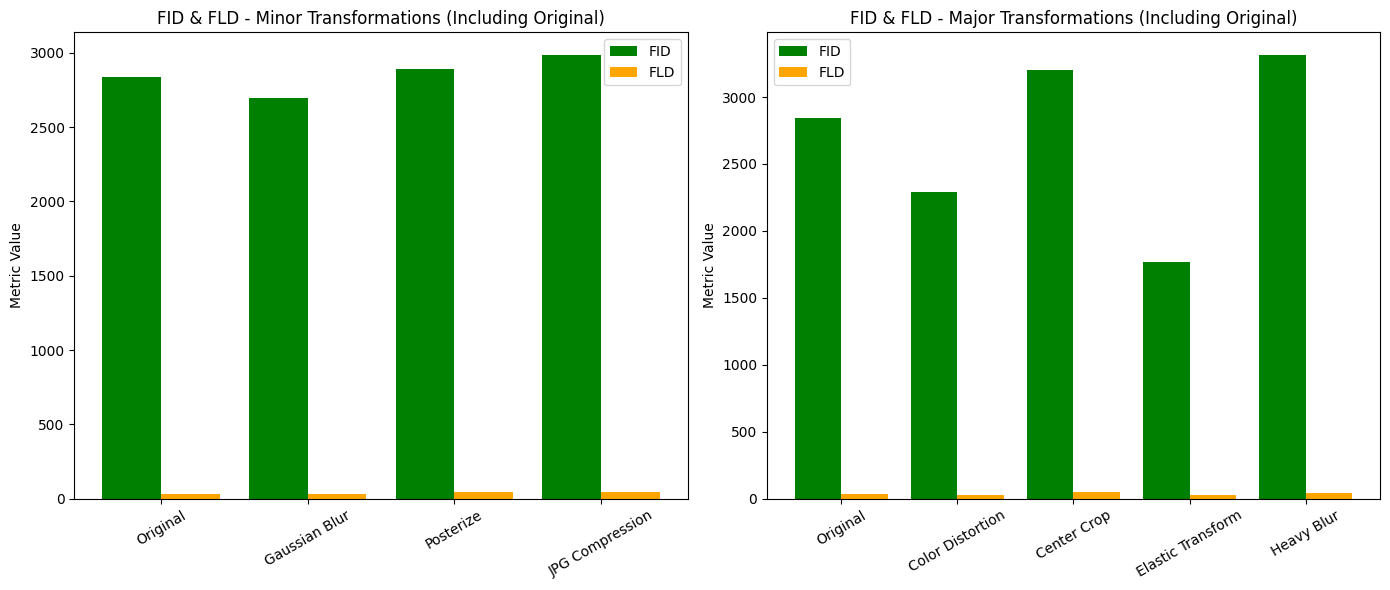

In [ ]:
# Include the original results in the dictionaries
fid_scores["Original"] = fid_original_D
fld_scores["Original"] = fld_original_D

# Separate minor and major transformation scores including the original
minor_fid_scores = {"Original": fid_original_D}
minor_fld_scores = {"Original": fld_original_D}
major_fid_scores = {"Original": fid_original_D}
major_fld_scores = {"Original": fld_original_D}

for name, value in fid_scores.items():
    if name in minor_feats_D.keys():
        minor_fid_scores[name] = value
    elif name in major_feats_D.keys():
        major_fid_scores[name] = value

for name, value in fld_scores.items():
    if name in minor_feats_D.keys():
        minor_fld_scores[name] = value
    elif name in major_feats_D.keys():
        major_fld_scores[name] = value

# Function to plot FID & FLD as adjacent bars for each transformation, including Original
def plot_fid_fld_adjacent(minor_fid, minor_fld, major_fid, major_fld):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    width = 0.4  # Width of bars

    # Plot Minor Transformations
    minor_categories = list(minor_fid.keys())
    x_minor = np.arange(len(minor_categories))  # X locations for bars

    axes[0].bar(x_minor - width/2, minor_fid.values(), width, color='green', label="FID")
    axes[0].bar(x_minor + width/2, minor_fld.values(), width, color='orange', label="FLD")
    axes[0].set_title("FID & FLD - Minor Transformations (Including Original)")
    axes[0].set_ylabel("Metric Value")
    axes[0].set_xticks(x_minor)
    axes[0].set_xticklabels(minor_categories, rotation=30)
    axes[0].legend()

    # Plot Major Transformations
    major_categories = list(major_fid.keys())
    x_major = np.arange(len(major_categories))  # X locations for bars

    axes[1].bar(x_major - width/2, major_fid.values(), width, color='green', label="FID")
    axes[1].bar(x_major + width/2, major_fld.values(), width, color='orange', label="FLD")
    axes[1].set_title("FID & FLD - Major Transformations (Including Original)")
    axes[1].set_ylabel("Metric Value")
    axes[1].set_xticks(x_major)
    axes[1].set_xticklabels(major_categories, rotation=30)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot adjacent bars for FID & FLD including the original results
plot_fid_fld_adjacent(minor_fid_scores, minor_fld_scores, major_fid_scores, major_fld_scores)


### INCEPTION feature space

In [ ]:
# load cifar data # load generate data # apply transformations # mapping with inception instead of dinov2 
# #calculate metrics # plot results 

In [ ]:
feature_extractor_I = InceptionFeatureExtractor()

In [72]:
# for inception
train_feat_I = feature_extractor_I.get_dataset_features(train_dataset)


In [73]:
test_feat_I= feature_extractor_I.get_dataset_features(test_dataset)


In [74]:
gen_feat_I= feature_extractor_I.get_dataset_features(generated_dataset)

In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID
from tqdm import tqdm
from PIL import Image


# ----------------------------
# Step 2: Optimized Dataset for Efficient Feature Extraction
# ----------------------------
INCEPTION_INPUT_SIZE = 299  # Required input size for Inception

class TransformedDataset(Dataset):
    def __init__(self, images):
        """Store images and apply transformation dynamically in __getitem__."""
        self.images = images  # List of PIL images (not pre-transformed)

        self.transform = transforms.Compose([
            transforms.Resize((INCEPTION_INPUT_SIZE, INCEPTION_INPUT_SIZE)),  # Resize for Inception
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(self.images[idx])  # Apply transformation dynamically
        return img, 0  # Dummy label

# ----------------------------
# Step 3: Function to Extract Features in Batches (Memory Efficient)
# ----------------------------
def extract_inception_features(transformed_datasets, feature_extractor, batch_size=32):
    transformed_features = {}

    for name, images in transformed_datasets.items():
        print(f"\n[INFO] Extracting features for: {name} ({len(images)} images)")

        dataset = TransformedDataset(images)  # Wrap images in Dataset
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

        features_list = []

        for batch_idx, (img_batch, _) in enumerate(tqdm(dataloader, desc=f"Processing {name}", leave=True)):
            img_batch = img_batch.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available

            # Extract features for the batch
            batch_features = feature_extractor.get_feature_batch(img_batch)
            features_list.append(batch_features.cpu().numpy())

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f" - Processed {batch_idx * batch_size}/{len(images)} images for {name}")

        # Combine all batches into a single feature matrix
        transformed_features[name] = np.vstack(features_list)

    return transformed_features

# ----------------------------
# Step 4: Apply Transformations & Extract Features Using Inception
# ----------------------------
# Extract features for transformed images in Inception feature space
minor_feats_I = extract_inception_features(minor_transformed_images, feature_extractor_I, batch_size=16)
major_feats_I = extract_inception_features(major_transformed_images, feature_extractor_I, batch_size=16)


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to C:\Users\oumni/.cache\torch\hub\checkpoints\pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:08<00:00, 11.8MB/s]



[INFO] Extracting features for: Gaussian Blur (10000 images)


Processing Gaussian Blur:   0%|          | 3/625 [00:00<01:36,  6.44it/s]

 - Processed 0/10000 images for Gaussian Blur


Processing Gaussian Blur:   2%|▏         | 13/625 [00:01<00:43, 13.98it/s]

 - Processed 160/10000 images for Gaussian Blur


Processing Gaussian Blur:   4%|▎         | 23/625 [00:01<00:39, 15.21it/s]

 - Processed 320/10000 images for Gaussian Blur


Processing Gaussian Blur:   5%|▌         | 33/625 [00:02<00:38, 15.27it/s]

 - Processed 480/10000 images for Gaussian Blur


Processing Gaussian Blur:   7%|▋         | 43/625 [00:03<00:34, 16.69it/s]

 - Processed 640/10000 images for Gaussian Blur


Processing Gaussian Blur:   8%|▊         | 53/625 [00:03<00:35, 16.15it/s]

 - Processed 800/10000 images for Gaussian Blur


Processing Gaussian Blur:  10%|█         | 63/625 [00:04<00:34, 16.51it/s]

 - Processed 960/10000 images for Gaussian Blur


Processing Gaussian Blur:  12%|█▏        | 73/625 [00:04<00:33, 16.26it/s]

 - Processed 1120/10000 images for Gaussian Blur


Processing Gaussian Blur:  13%|█▎        | 83/625 [00:05<00:33, 16.08it/s]

 - Processed 1280/10000 images for Gaussian Blur


Processing Gaussian Blur:  15%|█▍        | 93/625 [00:06<00:32, 16.53it/s]

 - Processed 1440/10000 images for Gaussian Blur


Processing Gaussian Blur:  16%|█▋        | 103/625 [00:06<00:31, 16.52it/s]

 - Processed 1600/10000 images for Gaussian Blur


Processing Gaussian Blur:  18%|█▊        | 113/625 [00:07<00:31, 16.01it/s]

 - Processed 1760/10000 images for Gaussian Blur


Processing Gaussian Blur:  20%|█▉        | 123/625 [00:07<00:30, 16.27it/s]

 - Processed 1920/10000 images for Gaussian Blur


Processing Gaussian Blur:  21%|██▏       | 133/625 [00:08<00:30, 16.07it/s]

 - Processed 2080/10000 images for Gaussian Blur


Processing Gaussian Blur:  23%|██▎       | 143/625 [00:09<00:29, 16.56it/s]

 - Processed 2240/10000 images for Gaussian Blur


Processing Gaussian Blur:  24%|██▍       | 153/625 [00:09<00:28, 16.54it/s]

 - Processed 2400/10000 images for Gaussian Blur


Processing Gaussian Blur:  26%|██▌       | 163/625 [00:10<00:28, 16.26it/s]

 - Processed 2560/10000 images for Gaussian Blur


Processing Gaussian Blur:  28%|██▊       | 173/625 [00:10<00:28, 16.10it/s]

 - Processed 2720/10000 images for Gaussian Blur


Processing Gaussian Blur:  29%|██▉       | 183/625 [00:11<00:27, 16.32it/s]

 - Processed 2880/10000 images for Gaussian Blur


Processing Gaussian Blur:  31%|███       | 193/625 [00:12<00:26, 16.28it/s]

 - Processed 3040/10000 images for Gaussian Blur


Processing Gaussian Blur:  32%|███▏      | 203/625 [00:12<00:26, 15.83it/s]

 - Processed 3200/10000 images for Gaussian Blur


Processing Gaussian Blur:  34%|███▍      | 213/625 [00:13<00:24, 17.06it/s]

 - Processed 3360/10000 images for Gaussian Blur


Processing Gaussian Blur:  36%|███▌      | 223/625 [00:14<00:25, 16.03it/s]

 - Processed 3520/10000 images for Gaussian Blur


Processing Gaussian Blur:  37%|███▋      | 233/625 [00:14<00:25, 15.45it/s]

 - Processed 3680/10000 images for Gaussian Blur


Processing Gaussian Blur:  39%|███▉      | 243/625 [00:15<00:23, 16.27it/s]

 - Processed 3840/10000 images for Gaussian Blur


Processing Gaussian Blur:  40%|████      | 253/625 [00:15<00:23, 15.98it/s]

 - Processed 4000/10000 images for Gaussian Blur


Processing Gaussian Blur:  42%|████▏     | 263/625 [00:16<00:22, 15.76it/s]

 - Processed 4160/10000 images for Gaussian Blur


Processing Gaussian Blur:  44%|████▎     | 273/625 [00:17<00:23, 14.75it/s]

 - Processed 4320/10000 images for Gaussian Blur


Processing Gaussian Blur:  45%|████▌     | 283/625 [00:17<00:21, 15.69it/s]

 - Processed 4480/10000 images for Gaussian Blur


Processing Gaussian Blur:  47%|████▋     | 293/625 [00:18<00:20, 16.15it/s]

 - Processed 4640/10000 images for Gaussian Blur


Processing Gaussian Blur:  48%|████▊     | 303/625 [00:19<00:19, 16.62it/s]

 - Processed 4800/10000 images for Gaussian Blur


Processing Gaussian Blur:  50%|█████     | 313/625 [00:19<00:19, 16.18it/s]

 - Processed 4960/10000 images for Gaussian Blur


Processing Gaussian Blur:  52%|█████▏    | 323/625 [00:20<00:18, 16.57it/s]

 - Processed 5120/10000 images for Gaussian Blur


Processing Gaussian Blur:  53%|█████▎    | 333/625 [00:21<00:18, 16.07it/s]

 - Processed 5280/10000 images for Gaussian Blur


Processing Gaussian Blur:  55%|█████▍    | 343/625 [00:21<00:17, 16.03it/s]

 - Processed 5440/10000 images for Gaussian Blur


Processing Gaussian Blur:  56%|█████▋    | 353/625 [00:22<00:16, 16.72it/s]

 - Processed 5600/10000 images for Gaussian Blur


Processing Gaussian Blur:  58%|█████▊    | 363/625 [00:22<00:15, 16.57it/s]

 - Processed 5760/10000 images for Gaussian Blur


Processing Gaussian Blur:  60%|█████▉    | 373/625 [00:23<00:15, 16.09it/s]

 - Processed 5920/10000 images for Gaussian Blur


Processing Gaussian Blur:  61%|██████▏   | 383/625 [00:24<00:14, 17.13it/s]

 - Processed 6080/10000 images for Gaussian Blur


Processing Gaussian Blur:  63%|██████▎   | 393/625 [00:24<00:14, 16.26it/s]

 - Processed 6240/10000 images for Gaussian Blur


Processing Gaussian Blur:  64%|██████▍   | 403/625 [00:25<00:13, 16.68it/s]

 - Processed 6400/10000 images for Gaussian Blur


Processing Gaussian Blur:  66%|██████▌   | 413/625 [00:25<00:13, 16.07it/s]

 - Processed 6560/10000 images for Gaussian Blur


Processing Gaussian Blur:  68%|██████▊   | 423/625 [00:26<00:12, 15.87it/s]

 - Processed 6720/10000 images for Gaussian Blur


Processing Gaussian Blur:  69%|██████▉   | 433/625 [00:27<00:16, 11.39it/s]

 - Processed 6880/10000 images for Gaussian Blur


Processing Gaussian Blur:  71%|███████   | 443/625 [00:28<00:12, 15.01it/s]

 - Processed 7040/10000 images for Gaussian Blur


Processing Gaussian Blur:  72%|███████▏  | 453/625 [00:28<00:10, 15.87it/s]

 - Processed 7200/10000 images for Gaussian Blur


Processing Gaussian Blur:  74%|███████▍  | 463/625 [00:29<00:09, 16.30it/s]

 - Processed 7360/10000 images for Gaussian Blur


Processing Gaussian Blur:  76%|███████▌  | 473/625 [00:29<00:09, 16.26it/s]

 - Processed 7520/10000 images for Gaussian Blur


Processing Gaussian Blur:  77%|███████▋  | 483/625 [00:30<00:08, 16.88it/s]

 - Processed 7680/10000 images for Gaussian Blur


Processing Gaussian Blur:  79%|███████▉  | 493/625 [00:31<00:08, 15.53it/s]

 - Processed 7840/10000 images for Gaussian Blur


Processing Gaussian Blur:  80%|████████  | 503/625 [00:31<00:07, 16.08it/s]

 - Processed 8000/10000 images for Gaussian Blur


Processing Gaussian Blur:  82%|████████▏ | 513/625 [00:32<00:07, 15.73it/s]

 - Processed 8160/10000 images for Gaussian Blur


Processing Gaussian Blur:  84%|████████▎ | 523/625 [00:33<00:06, 16.07it/s]

 - Processed 8320/10000 images for Gaussian Blur


Processing Gaussian Blur:  85%|████████▌ | 533/625 [00:33<00:05, 15.80it/s]

 - Processed 8480/10000 images for Gaussian Blur


Processing Gaussian Blur:  87%|████████▋ | 543/625 [00:34<00:04, 16.40it/s]

 - Processed 8640/10000 images for Gaussian Blur


Processing Gaussian Blur:  88%|████████▊ | 553/625 [00:34<00:04, 15.28it/s]

 - Processed 8800/10000 images for Gaussian Blur


Processing Gaussian Blur:  90%|█████████ | 563/625 [00:35<00:03, 16.09it/s]

 - Processed 8960/10000 images for Gaussian Blur


Processing Gaussian Blur:  92%|█████████▏| 573/625 [00:36<00:03, 15.74it/s]

 - Processed 9120/10000 images for Gaussian Blur


Processing Gaussian Blur:  93%|█████████▎| 583/625 [00:36<00:02, 17.21it/s]

 - Processed 9280/10000 images for Gaussian Blur


Processing Gaussian Blur:  95%|█████████▍| 593/625 [00:37<00:01, 17.40it/s]

 - Processed 9440/10000 images for Gaussian Blur


Processing Gaussian Blur:  96%|█████████▋| 603/625 [00:37<00:01, 17.33it/s]

 - Processed 9600/10000 images for Gaussian Blur


Processing Gaussian Blur:  98%|█████████▊| 613/625 [00:38<00:00, 17.40it/s]

 - Processed 9760/10000 images for Gaussian Blur


Processing Gaussian Blur: 100%|█████████▉| 623/625 [00:39<00:00, 17.30it/s]

 - Processed 9920/10000 images for Gaussian Blur


Processing Gaussian Blur: 100%|██████████| 625/625 [00:39<00:00, 15.94it/s]



[INFO] Extracting features for: Posterize (10000 images)


Processing Posterize:   0%|          | 2/625 [00:00<00:36, 17.17it/s]

 - Processed 0/10000 images for Posterize


Processing Posterize:   2%|▏         | 14/625 [00:00<00:34, 17.66it/s]

 - Processed 160/10000 images for Posterize


Processing Posterize:   4%|▍         | 24/625 [00:01<00:34, 17.55it/s]

 - Processed 320/10000 images for Posterize


Processing Posterize:   5%|▌         | 34/625 [00:01<00:33, 17.61it/s]

 - Processed 480/10000 images for Posterize


Processing Posterize:   7%|▋         | 44/625 [00:02<00:32, 17.63it/s]

 - Processed 640/10000 images for Posterize


Processing Posterize:   9%|▊         | 54/625 [00:03<00:32, 17.67it/s]

 - Processed 800/10000 images for Posterize


Processing Posterize:  10%|█         | 64/625 [00:03<00:31, 17.60it/s]

 - Processed 960/10000 images for Posterize


Processing Posterize:  12%|█▏        | 74/625 [00:04<00:31, 17.56it/s]

 - Processed 1120/10000 images for Posterize


Processing Posterize:  13%|█▎        | 84/625 [00:04<00:31, 17.43it/s]

 - Processed 1280/10000 images for Posterize


Processing Posterize:  15%|█▌        | 94/625 [00:05<00:30, 17.57it/s]

 - Processed 1440/10000 images for Posterize


Processing Posterize:  17%|█▋        | 104/625 [00:05<00:29, 17.50it/s]

 - Processed 1600/10000 images for Posterize


Processing Posterize:  18%|█▊        | 114/625 [00:06<00:28, 17.67it/s]

 - Processed 1760/10000 images for Posterize


Processing Posterize:  20%|█▉        | 124/625 [00:07<00:28, 17.64it/s]

 - Processed 1920/10000 images for Posterize


Processing Posterize:  21%|██▏       | 134/625 [00:07<00:28, 17.40it/s]

 - Processed 2080/10000 images for Posterize


Processing Posterize:  23%|██▎       | 144/625 [00:08<00:27, 17.43it/s]

 - Processed 2240/10000 images for Posterize


Processing Posterize:  25%|██▍       | 154/625 [00:08<00:27, 17.39it/s]

 - Processed 2400/10000 images for Posterize


Processing Posterize:  26%|██▌       | 164/625 [00:09<00:26, 17.40it/s]

 - Processed 2560/10000 images for Posterize


Processing Posterize:  28%|██▊       | 174/625 [00:09<00:25, 17.38it/s]

 - Processed 2720/10000 images for Posterize


Processing Posterize:  29%|██▉       | 184/625 [00:10<00:25, 17.57it/s]

 - Processed 2880/10000 images for Posterize


Processing Posterize:  31%|███       | 194/625 [00:11<00:24, 17.43it/s]

 - Processed 3040/10000 images for Posterize


Processing Posterize:  33%|███▎      | 204/625 [00:11<00:23, 17.64it/s]

 - Processed 3200/10000 images for Posterize


Processing Posterize:  34%|███▍      | 214/625 [00:12<00:23, 17.54it/s]

 - Processed 3360/10000 images for Posterize


Processing Posterize:  36%|███▌      | 224/625 [00:12<00:22, 17.63it/s]

 - Processed 3520/10000 images for Posterize


Processing Posterize:  37%|███▋      | 234/625 [00:13<00:21, 17.86it/s]

 - Processed 3680/10000 images for Posterize


Processing Posterize:  39%|███▉      | 244/625 [00:13<00:21, 17.50it/s]

 - Processed 3840/10000 images for Posterize


Processing Posterize:  41%|████      | 254/625 [00:14<00:21, 17.48it/s]

 - Processed 4000/10000 images for Posterize


Processing Posterize:  42%|████▏     | 264/625 [00:15<00:20, 17.44it/s]

 - Processed 4160/10000 images for Posterize


Processing Posterize:  44%|████▍     | 274/625 [00:15<00:19, 17.61it/s]

 - Processed 4320/10000 images for Posterize


Processing Posterize:  45%|████▌     | 284/625 [00:16<00:19, 17.49it/s]

 - Processed 4480/10000 images for Posterize


Processing Posterize:  47%|████▋     | 294/625 [00:16<00:19, 17.38it/s]

 - Processed 4640/10000 images for Posterize


Processing Posterize:  49%|████▊     | 304/625 [00:17<00:18, 17.53it/s]

 - Processed 4800/10000 images for Posterize


Processing Posterize:  50%|█████     | 314/625 [00:17<00:17, 17.54it/s]

 - Processed 4960/10000 images for Posterize


Processing Posterize:  52%|█████▏    | 324/625 [00:18<00:17, 17.64it/s]

 - Processed 5120/10000 images for Posterize


Processing Posterize:  53%|█████▎    | 334/625 [00:19<00:16, 17.56it/s]

 - Processed 5280/10000 images for Posterize


Processing Posterize:  55%|█████▌    | 344/625 [00:19<00:15, 17.59it/s]

 - Processed 5440/10000 images for Posterize


Processing Posterize:  57%|█████▋    | 354/625 [00:20<00:15, 17.17it/s]

 - Processed 5600/10000 images for Posterize


Processing Posterize:  58%|█████▊    | 364/625 [00:20<00:15, 17.22it/s]

 - Processed 5760/10000 images for Posterize


Processing Posterize:  60%|█████▉    | 374/625 [00:21<00:14, 17.51it/s]

 - Processed 5920/10000 images for Posterize


Processing Posterize:  61%|██████▏   | 384/625 [00:21<00:13, 17.48it/s]

 - Processed 6080/10000 images for Posterize


Processing Posterize:  63%|██████▎   | 394/625 [00:22<00:13, 17.24it/s]

 - Processed 6240/10000 images for Posterize


Processing Posterize:  65%|██████▍   | 404/625 [00:23<00:12, 17.22it/s]

 - Processed 6400/10000 images for Posterize


Processing Posterize:  66%|██████▌   | 414/625 [00:23<00:12, 17.43it/s]

 - Processed 6560/10000 images for Posterize


Processing Posterize:  68%|██████▊   | 424/625 [00:24<00:11, 17.49it/s]

 - Processed 6720/10000 images for Posterize


Processing Posterize:  69%|██████▉   | 434/625 [00:24<00:10, 17.47it/s]

 - Processed 6880/10000 images for Posterize


Processing Posterize:  71%|███████   | 444/625 [00:25<00:10, 17.50it/s]

 - Processed 7040/10000 images for Posterize


Processing Posterize:  73%|███████▎  | 454/625 [00:26<00:09, 17.54it/s]

 - Processed 7200/10000 images for Posterize


Processing Posterize:  74%|███████▍  | 464/625 [00:26<00:09, 17.38it/s]

 - Processed 7360/10000 images for Posterize


Processing Posterize:  76%|███████▌  | 474/625 [00:27<00:08, 17.44it/s]

 - Processed 7520/10000 images for Posterize


Processing Posterize:  77%|███████▋  | 484/625 [00:27<00:08, 17.25it/s]

 - Processed 7680/10000 images for Posterize


Processing Posterize:  79%|███████▉  | 494/625 [00:28<00:07, 17.13it/s]

 - Processed 7840/10000 images for Posterize


Processing Posterize:  81%|████████  | 504/625 [00:28<00:07, 17.11it/s]

 - Processed 8000/10000 images for Posterize


Processing Posterize:  82%|████████▏ | 514/625 [00:29<00:06, 17.12it/s]

 - Processed 8160/10000 images for Posterize


Processing Posterize:  84%|████████▍ | 524/625 [00:30<00:06, 16.19it/s]

 - Processed 8320/10000 images for Posterize


Processing Posterize:  85%|████████▌ | 534/625 [00:30<00:05, 17.07it/s]

 - Processed 8480/10000 images for Posterize


Processing Posterize:  87%|████████▋ | 544/625 [00:31<00:04, 17.30it/s]

 - Processed 8640/10000 images for Posterize


Processing Posterize:  89%|████████▊ | 554/625 [00:31<00:04, 17.45it/s]

 - Processed 8800/10000 images for Posterize


Processing Posterize:  90%|█████████ | 564/625 [00:32<00:03, 17.46it/s]

 - Processed 8960/10000 images for Posterize


Processing Posterize:  92%|█████████▏| 574/625 [00:33<00:03, 16.85it/s]

 - Processed 9120/10000 images for Posterize


Processing Posterize:  93%|█████████▎| 584/625 [00:33<00:02, 17.21it/s]

 - Processed 9280/10000 images for Posterize


Processing Posterize:  95%|█████████▌| 594/625 [00:34<00:01, 17.06it/s]

 - Processed 9440/10000 images for Posterize


Processing Posterize:  96%|█████████▋| 602/625 [00:34<00:01, 17.02it/s]

 - Processed 9600/10000 images for Posterize


Processing Posterize:  98%|█████████▊| 614/625 [00:35<00:00, 17.37it/s]

 - Processed 9760/10000 images for Posterize


Processing Posterize: 100%|█████████▉| 624/625 [00:35<00:00, 17.41it/s]

 - Processed 9920/10000 images for Posterize


Processing Posterize: 100%|██████████| 625/625 [00:36<00:00, 17.35it/s]



[INFO] Extracting features for: JPG Compression (10000 images)


Processing JPG Compression:   0%|          | 2/625 [00:00<00:36, 17.08it/s]

 - Processed 0/10000 images for JPG Compression


Processing JPG Compression:   2%|▏         | 14/625 [00:00<00:35, 17.20it/s]

 - Processed 160/10000 images for JPG Compression


Processing JPG Compression:   4%|▍         | 24/625 [00:01<00:34, 17.17it/s]

 - Processed 320/10000 images for JPG Compression


Processing JPG Compression:   5%|▌         | 34/625 [00:01<00:34, 17.34it/s]

 - Processed 480/10000 images for JPG Compression


Processing JPG Compression:   7%|▋         | 44/625 [00:02<00:33, 17.45it/s]

 - Processed 640/10000 images for JPG Compression


Processing JPG Compression:   9%|▊         | 54/625 [00:03<00:32, 17.51it/s]

 - Processed 800/10000 images for JPG Compression


Processing JPG Compression:  10%|█         | 64/625 [00:03<00:32, 17.31it/s]

 - Processed 960/10000 images for JPG Compression


Processing JPG Compression:  12%|█▏        | 74/625 [00:04<00:31, 17.39it/s]

 - Processed 1120/10000 images for JPG Compression


Processing JPG Compression:  13%|█▎        | 84/625 [00:04<00:32, 16.79it/s]

 - Processed 1280/10000 images for JPG Compression


Processing JPG Compression:  15%|█▌        | 94/625 [00:05<00:30, 17.39it/s]

 - Processed 1440/10000 images for JPG Compression


Processing JPG Compression:  17%|█▋        | 104/625 [00:06<00:30, 17.37it/s]

 - Processed 1600/10000 images for JPG Compression


Processing JPG Compression:  18%|█▊        | 114/625 [00:06<00:29, 17.52it/s]

 - Processed 1760/10000 images for JPG Compression


Processing JPG Compression:  20%|█▉        | 124/625 [00:07<00:28, 17.56it/s]

 - Processed 1920/10000 images for JPG Compression


Processing JPG Compression:  21%|██▏       | 134/625 [00:07<00:28, 17.44it/s]

 - Processed 2080/10000 images for JPG Compression


Processing JPG Compression:  23%|██▎       | 144/625 [00:08<00:27, 17.39it/s]

 - Processed 2240/10000 images for JPG Compression


Processing JPG Compression:  25%|██▍       | 154/625 [00:08<00:27, 17.41it/s]

 - Processed 2400/10000 images for JPG Compression


Processing JPG Compression:  26%|██▌       | 164/625 [00:09<00:26, 17.25it/s]

 - Processed 2560/10000 images for JPG Compression


Processing JPG Compression:  28%|██▊       | 174/625 [00:10<00:26, 17.33it/s]

 - Processed 2720/10000 images for JPG Compression


Processing JPG Compression:  29%|██▉       | 184/625 [00:10<00:25, 17.57it/s]

 - Processed 2880/10000 images for JPG Compression


Processing JPG Compression:  31%|███       | 192/625 [00:11<00:24, 17.43it/s]

 - Processed 3040/10000 images for JPG Compression


Processing JPG Compression:  33%|███▎      | 204/625 [00:11<00:24, 17.51it/s]

 - Processed 3200/10000 images for JPG Compression


Processing JPG Compression:  34%|███▍      | 214/625 [00:12<00:23, 17.52it/s]

 - Processed 3360/10000 images for JPG Compression


Processing JPG Compression:  36%|███▌      | 224/625 [00:12<00:23, 16.97it/s]

 - Processed 3520/10000 images for JPG Compression


Processing JPG Compression:  37%|███▋      | 234/625 [00:13<00:22, 17.28it/s]

 - Processed 3680/10000 images for JPG Compression


Processing JPG Compression:  39%|███▉      | 244/625 [00:14<00:22, 17.26it/s]

 - Processed 3840/10000 images for JPG Compression


Processing JPG Compression:  41%|████      | 254/625 [00:14<00:21, 17.44it/s]

 - Processed 4000/10000 images for JPG Compression


Processing JPG Compression:  42%|████▏     | 264/625 [00:15<00:20, 17.47it/s]

 - Processed 4160/10000 images for JPG Compression


Processing JPG Compression:  44%|████▍     | 274/625 [00:15<00:20, 17.45it/s]

 - Processed 4320/10000 images for JPG Compression


Processing JPG Compression:  45%|████▌     | 284/625 [00:16<00:19, 17.39it/s]

 - Processed 4480/10000 images for JPG Compression


Processing JPG Compression:  47%|████▋     | 294/625 [00:16<00:18, 17.48it/s]

 - Processed 4640/10000 images for JPG Compression


Processing JPG Compression:  49%|████▊     | 304/625 [00:17<00:18, 17.59it/s]

 - Processed 4800/10000 images for JPG Compression


Processing JPG Compression:  50%|█████     | 314/625 [00:18<00:17, 17.37it/s]

 - Processed 4960/10000 images for JPG Compression


Processing JPG Compression:  52%|█████▏    | 324/625 [00:18<00:17, 17.45it/s]

 - Processed 5120/10000 images for JPG Compression


Processing JPG Compression:  53%|█████▎    | 334/625 [00:19<00:16, 17.58it/s]

 - Processed 5280/10000 images for JPG Compression


Processing JPG Compression:  55%|█████▌    | 344/625 [00:19<00:16, 17.55it/s]

 - Processed 5440/10000 images for JPG Compression


Processing JPG Compression:  57%|█████▋    | 354/625 [00:20<00:15, 17.32it/s]

 - Processed 5600/10000 images for JPG Compression


Processing JPG Compression:  58%|█████▊    | 364/625 [00:21<00:15, 17.25it/s]

 - Processed 5760/10000 images for JPG Compression


Processing JPG Compression:  60%|█████▉    | 374/625 [00:21<00:14, 17.33it/s]

 - Processed 5920/10000 images for JPG Compression


Processing JPG Compression:  61%|██████▏   | 384/625 [00:22<00:13, 17.39it/s]

 - Processed 6080/10000 images for JPG Compression


Processing JPG Compression:  63%|██████▎   | 394/625 [00:22<00:13, 17.61it/s]

 - Processed 6240/10000 images for JPG Compression


Processing JPG Compression:  65%|██████▍   | 404/625 [00:23<00:12, 17.49it/s]

 - Processed 6400/10000 images for JPG Compression


Processing JPG Compression:  66%|██████▌   | 414/625 [00:23<00:11, 17.59it/s]

 - Processed 6560/10000 images for JPG Compression


Processing JPG Compression:  68%|██████▊   | 424/625 [00:24<00:11, 17.42it/s]

 - Processed 6720/10000 images for JPG Compression


Processing JPG Compression:  69%|██████▉   | 434/625 [00:25<00:10, 17.53it/s]

 - Processed 6880/10000 images for JPG Compression


Processing JPG Compression:  71%|███████   | 444/625 [00:25<00:10, 17.59it/s]

 - Processed 7040/10000 images for JPG Compression


Processing JPG Compression:  73%|███████▎  | 454/625 [00:26<00:09, 17.55it/s]

 - Processed 7200/10000 images for JPG Compression


Processing JPG Compression:  74%|███████▍  | 464/625 [00:26<00:09, 17.57it/s]

 - Processed 7360/10000 images for JPG Compression


Processing JPG Compression:  76%|███████▌  | 474/625 [00:27<00:08, 17.48it/s]

 - Processed 7520/10000 images for JPG Compression


Processing JPG Compression:  77%|███████▋  | 484/625 [00:27<00:08, 17.61it/s]

 - Processed 7680/10000 images for JPG Compression


Processing JPG Compression:  79%|███████▉  | 494/625 [00:28<00:07, 17.42it/s]

 - Processed 7840/10000 images for JPG Compression


Processing JPG Compression:  81%|████████  | 504/625 [00:29<00:06, 17.29it/s]

 - Processed 8000/10000 images for JPG Compression


Processing JPG Compression:  82%|████████▏ | 514/625 [00:29<00:06, 17.51it/s]

 - Processed 8160/10000 images for JPG Compression


Processing JPG Compression:  84%|████████▍ | 524/625 [00:30<00:05, 17.56it/s]

 - Processed 8320/10000 images for JPG Compression


Processing JPG Compression:  85%|████████▌ | 534/625 [00:30<00:05, 17.51it/s]

 - Processed 8480/10000 images for JPG Compression


Processing JPG Compression:  87%|████████▋ | 544/625 [00:31<00:04, 17.36it/s]

 - Processed 8640/10000 images for JPG Compression


Processing JPG Compression:  89%|████████▊ | 554/625 [00:31<00:04, 17.48it/s]

 - Processed 8800/10000 images for JPG Compression


Processing JPG Compression:  90%|█████████ | 564/625 [00:32<00:03, 17.60it/s]

 - Processed 8960/10000 images for JPG Compression


Processing JPG Compression:  92%|█████████▏| 574/625 [00:33<00:02, 17.42it/s]

 - Processed 9120/10000 images for JPG Compression


Processing JPG Compression:  93%|█████████▎| 584/625 [00:33<00:02, 17.60it/s]

 - Processed 9280/10000 images for JPG Compression


Processing JPG Compression:  95%|█████████▌| 594/625 [00:34<00:01, 17.53it/s]

 - Processed 9440/10000 images for JPG Compression


Processing JPG Compression:  97%|█████████▋| 604/625 [00:34<00:01, 17.45it/s]

 - Processed 9600/10000 images for JPG Compression


Processing JPG Compression:  98%|█████████▊| 614/625 [00:35<00:00, 17.50it/s]

 - Processed 9760/10000 images for JPG Compression


Processing JPG Compression: 100%|█████████▉| 624/625 [00:35<00:00, 17.43it/s]

 - Processed 9920/10000 images for JPG Compression


Processing JPG Compression: 100%|██████████| 625/625 [00:36<00:00, 17.36it/s]



[INFO] Extracting features for: Color Distortion (10000 images)


Processing Color Distortion:   0%|          | 2/625 [00:00<00:36, 17.22it/s]

 - Processed 0/10000 images for Color Distortion


Processing Color Distortion:   2%|▏         | 14/625 [00:00<00:35, 17.44it/s]

 - Processed 160/10000 images for Color Distortion


Processing Color Distortion:   4%|▍         | 24/625 [00:01<00:34, 17.42it/s]

 - Processed 320/10000 images for Color Distortion


Processing Color Distortion:   5%|▌         | 34/625 [00:01<00:33, 17.68it/s]

 - Processed 480/10000 images for Color Distortion


Processing Color Distortion:   7%|▋         | 44/625 [00:02<00:33, 17.38it/s]

 - Processed 640/10000 images for Color Distortion


Processing Color Distortion:   9%|▊         | 54/625 [00:03<00:32, 17.59it/s]

 - Processed 800/10000 images for Color Distortion


Processing Color Distortion:  10%|█         | 64/625 [00:03<00:32, 17.46it/s]

 - Processed 960/10000 images for Color Distortion


Processing Color Distortion:  12%|█▏        | 74/625 [00:04<00:31, 17.47it/s]

 - Processed 1120/10000 images for Color Distortion


Processing Color Distortion:  13%|█▎        | 84/625 [00:04<00:31, 17.15it/s]

 - Processed 1280/10000 images for Color Distortion


Processing Color Distortion:  15%|█▌        | 94/625 [00:05<00:30, 17.40it/s]

 - Processed 1440/10000 images for Color Distortion


Processing Color Distortion:  17%|█▋        | 104/625 [00:05<00:29, 17.43it/s]

 - Processed 1600/10000 images for Color Distortion


Processing Color Distortion:  18%|█▊        | 114/625 [00:06<00:29, 17.39it/s]

 - Processed 1760/10000 images for Color Distortion


Processing Color Distortion:  20%|█▉        | 124/625 [00:07<00:28, 17.47it/s]

 - Processed 1920/10000 images for Color Distortion


Processing Color Distortion:  21%|██▏       | 134/625 [00:07<00:28, 17.47it/s]

 - Processed 2080/10000 images for Color Distortion


Processing Color Distortion:  23%|██▎       | 144/625 [00:08<00:27, 17.54it/s]

 - Processed 2240/10000 images for Color Distortion


Processing Color Distortion:  25%|██▍       | 154/625 [00:08<00:27, 17.26it/s]

 - Processed 2400/10000 images for Color Distortion


Processing Color Distortion:  26%|██▌       | 164/625 [00:09<00:26, 17.49it/s]

 - Processed 2560/10000 images for Color Distortion


Processing Color Distortion:  28%|██▊       | 174/625 [00:10<00:25, 17.49it/s]

 - Processed 2720/10000 images for Color Distortion


Processing Color Distortion:  29%|██▉       | 184/625 [00:10<00:25, 17.36it/s]

 - Processed 2880/10000 images for Color Distortion


Processing Color Distortion:  31%|███       | 194/625 [00:11<00:24, 17.61it/s]

 - Processed 3040/10000 images for Color Distortion


Processing Color Distortion:  33%|███▎      | 204/625 [00:11<00:24, 17.41it/s]

 - Processed 3200/10000 images for Color Distortion


Processing Color Distortion:  34%|███▍      | 214/625 [00:12<00:23, 17.51it/s]

 - Processed 3360/10000 images for Color Distortion


Processing Color Distortion:  36%|███▌      | 224/625 [00:12<00:23, 17.32it/s]

 - Processed 3520/10000 images for Color Distortion


Processing Color Distortion:  37%|███▋      | 234/625 [00:13<00:22, 17.29it/s]

 - Processed 3680/10000 images for Color Distortion


Processing Color Distortion:  39%|███▉      | 244/625 [00:14<00:21, 17.40it/s]

 - Processed 3840/10000 images for Color Distortion


Processing Color Distortion:  41%|████      | 254/625 [00:14<00:21, 17.44it/s]

 - Processed 4000/10000 images for Color Distortion


Processing Color Distortion:  42%|████▏     | 264/625 [00:15<00:20, 17.48it/s]

 - Processed 4160/10000 images for Color Distortion


Processing Color Distortion:  44%|████▍     | 274/625 [00:15<00:20, 17.51it/s]

 - Processed 4320/10000 images for Color Distortion


Processing Color Distortion:  45%|████▌     | 284/625 [00:16<00:19, 17.24it/s]

 - Processed 4480/10000 images for Color Distortion


Processing Color Distortion:  47%|████▋     | 292/625 [00:16<00:19, 17.45it/s]

 - Processed 4640/10000 images for Color Distortion


Processing Color Distortion:  49%|████▊     | 304/625 [00:17<00:18, 17.50it/s]

 - Processed 4800/10000 images for Color Distortion


Processing Color Distortion:  50%|█████     | 314/625 [00:18<00:17, 17.54it/s]

 - Processed 4960/10000 images for Color Distortion


Processing Color Distortion:  52%|█████▏    | 322/625 [00:18<00:17, 17.48it/s]

 - Processed 5120/10000 images for Color Distortion


Processing Color Distortion:  53%|█████▎    | 334/625 [00:19<00:16, 17.49it/s]

 - Processed 5280/10000 images for Color Distortion


Processing Color Distortion:  55%|█████▌    | 344/625 [00:19<00:16, 17.48it/s]

 - Processed 5440/10000 images for Color Distortion


Processing Color Distortion:  57%|█████▋    | 354/625 [00:20<00:15, 17.27it/s]

 - Processed 5600/10000 images for Color Distortion


Processing Color Distortion:  58%|█████▊    | 364/625 [00:20<00:14, 17.47it/s]

 - Processed 5760/10000 images for Color Distortion


Processing Color Distortion:  60%|█████▉    | 374/625 [00:21<00:14, 17.51it/s]

 - Processed 5920/10000 images for Color Distortion


Processing Color Distortion:  61%|██████▏   | 384/625 [00:22<00:13, 17.41it/s]

 - Processed 6080/10000 images for Color Distortion


Processing Color Distortion:  63%|██████▎   | 394/625 [00:22<00:13, 17.55it/s]

 - Processed 6240/10000 images for Color Distortion


Processing Color Distortion:  65%|██████▍   | 404/625 [00:23<00:12, 17.56it/s]

 - Processed 6400/10000 images for Color Distortion


Processing Color Distortion:  66%|██████▌   | 414/625 [00:23<00:12, 17.39it/s]

 - Processed 6560/10000 images for Color Distortion


Processing Color Distortion:  68%|██████▊   | 424/625 [00:24<00:11, 17.25it/s]

 - Processed 6720/10000 images for Color Distortion


Processing Color Distortion:  69%|██████▉   | 434/625 [00:25<00:11, 17.30it/s]

 - Processed 6880/10000 images for Color Distortion


Processing Color Distortion:  71%|███████   | 444/625 [00:25<00:10, 17.28it/s]

 - Processed 7040/10000 images for Color Distortion


Processing Color Distortion:  73%|███████▎  | 454/625 [00:26<00:09, 17.36it/s]

 - Processed 7200/10000 images for Color Distortion


Processing Color Distortion:  74%|███████▍  | 464/625 [00:26<00:09, 17.49it/s]

 - Processed 7360/10000 images for Color Distortion


Processing Color Distortion:  76%|███████▌  | 474/625 [00:27<00:08, 17.45it/s]

 - Processed 7520/10000 images for Color Distortion


Processing Color Distortion:  77%|███████▋  | 484/625 [00:27<00:08, 17.37it/s]

 - Processed 7680/10000 images for Color Distortion


Processing Color Distortion:  79%|███████▉  | 494/625 [00:28<00:07, 17.32it/s]

 - Processed 7840/10000 images for Color Distortion


Processing Color Distortion:  81%|████████  | 504/625 [00:29<00:06, 17.48it/s]

 - Processed 8000/10000 images for Color Distortion


Processing Color Distortion:  82%|████████▏ | 514/625 [00:29<00:06, 17.49it/s]

 - Processed 8160/10000 images for Color Distortion


Processing Color Distortion:  84%|████████▍ | 524/625 [00:30<00:05, 17.51it/s]

 - Processed 8320/10000 images for Color Distortion


Processing Color Distortion:  85%|████████▌ | 534/625 [00:30<00:05, 17.40it/s]

 - Processed 8480/10000 images for Color Distortion


Processing Color Distortion:  87%|████████▋ | 544/625 [00:31<00:04, 17.34it/s]

 - Processed 8640/10000 images for Color Distortion


Processing Color Distortion:  89%|████████▊ | 554/625 [00:31<00:04, 17.47it/s]

 - Processed 8800/10000 images for Color Distortion


Processing Color Distortion:  90%|█████████ | 564/625 [00:32<00:03, 17.42it/s]

 - Processed 8960/10000 images for Color Distortion


Processing Color Distortion:  92%|█████████▏| 574/625 [00:33<00:02, 17.52it/s]

 - Processed 9120/10000 images for Color Distortion


Processing Color Distortion:  93%|█████████▎| 584/625 [00:33<00:02, 17.45it/s]

 - Processed 9280/10000 images for Color Distortion


Processing Color Distortion:  95%|█████████▌| 594/625 [00:34<00:01, 17.54it/s]

 - Processed 9440/10000 images for Color Distortion


Processing Color Distortion:  97%|█████████▋| 604/625 [00:34<00:01, 17.65it/s]

 - Processed 9600/10000 images for Color Distortion


Processing Color Distortion:  98%|█████████▊| 614/625 [00:35<00:00, 17.40it/s]

 - Processed 9760/10000 images for Color Distortion


Processing Color Distortion: 100%|█████████▉| 624/625 [00:35<00:00, 17.52it/s]

 - Processed 9920/10000 images for Color Distortion


Processing Color Distortion: 100%|██████████| 625/625 [00:36<00:00, 17.35it/s]



[INFO] Extracting features for: Center Crop (10000 images)


Processing Center Crop:   0%|          | 2/625 [00:00<00:35, 17.40it/s]

 - Processed 0/10000 images for Center Crop


Processing Center Crop:   2%|▏         | 14/625 [00:00<00:35, 17.45it/s]

 - Processed 160/10000 images for Center Crop


Processing Center Crop:   4%|▍         | 24/625 [00:01<00:34, 17.60it/s]

 - Processed 320/10000 images for Center Crop


Processing Center Crop:   5%|▌         | 34/625 [00:01<00:33, 17.84it/s]

 - Processed 480/10000 images for Center Crop


Processing Center Crop:   7%|▋         | 44/625 [00:02<00:32, 17.81it/s]

 - Processed 640/10000 images for Center Crop


Processing Center Crop:   9%|▊         | 54/625 [00:03<00:32, 17.62it/s]

 - Processed 800/10000 images for Center Crop


Processing Center Crop:  10%|█         | 64/625 [00:03<00:31, 17.82it/s]

 - Processed 960/10000 images for Center Crop


Processing Center Crop:  12%|█▏        | 74/625 [00:04<00:30, 17.79it/s]

 - Processed 1120/10000 images for Center Crop


Processing Center Crop:  13%|█▎        | 84/625 [00:04<00:30, 17.70it/s]

 - Processed 1280/10000 images for Center Crop


Processing Center Crop:  15%|█▌        | 94/625 [00:05<00:29, 17.84it/s]

 - Processed 1440/10000 images for Center Crop


Processing Center Crop:  17%|█▋        | 104/625 [00:05<00:29, 17.51it/s]

 - Processed 1600/10000 images for Center Crop


Processing Center Crop:  18%|█▊        | 114/625 [00:06<00:28, 17.83it/s]

 - Processed 1760/10000 images for Center Crop


Processing Center Crop:  20%|█▉        | 124/625 [00:07<00:28, 17.81it/s]

 - Processed 1920/10000 images for Center Crop


Processing Center Crop:  21%|██▏       | 134/625 [00:07<00:27, 17.61it/s]

 - Processed 2080/10000 images for Center Crop


Processing Center Crop:  23%|██▎       | 144/625 [00:08<00:26, 18.05it/s]

 - Processed 2240/10000 images for Center Crop


Processing Center Crop:  25%|██▍       | 154/625 [00:08<00:26, 17.74it/s]

 - Processed 2400/10000 images for Center Crop


Processing Center Crop:  26%|██▌       | 164/625 [00:09<00:25, 17.81it/s]

 - Processed 2560/10000 images for Center Crop


Processing Center Crop:  28%|██▊       | 174/625 [00:09<00:25, 17.75it/s]

 - Processed 2720/10000 images for Center Crop


Processing Center Crop:  29%|██▉       | 184/625 [00:10<00:25, 17.47it/s]

 - Processed 2880/10000 images for Center Crop


Processing Center Crop:  31%|███       | 194/625 [00:10<00:24, 17.79it/s]

 - Processed 3040/10000 images for Center Crop


Processing Center Crop:  33%|███▎      | 204/625 [00:11<00:23, 17.68it/s]

 - Processed 3200/10000 images for Center Crop


Processing Center Crop:  34%|███▍      | 214/625 [00:12<00:23, 17.75it/s]

 - Processed 3360/10000 images for Center Crop


Processing Center Crop:  36%|███▌      | 224/625 [00:12<00:22, 17.82it/s]

 - Processed 3520/10000 images for Center Crop


Processing Center Crop:  37%|███▋      | 234/625 [00:13<00:21, 17.88it/s]

 - Processed 3680/10000 images for Center Crop


Processing Center Crop:  39%|███▉      | 244/625 [00:13<00:21, 17.63it/s]

 - Processed 3840/10000 images for Center Crop


Processing Center Crop:  41%|████      | 254/625 [00:14<00:21, 17.38it/s]

 - Processed 4000/10000 images for Center Crop


Processing Center Crop:  42%|████▏     | 264/625 [00:14<00:20, 17.80it/s]

 - Processed 4160/10000 images for Center Crop


Processing Center Crop:  44%|████▍     | 274/625 [00:15<00:19, 17.79it/s]

 - Processed 4320/10000 images for Center Crop


Processing Center Crop:  45%|████▌     | 284/625 [00:16<00:19, 17.92it/s]

 - Processed 4480/10000 images for Center Crop


Processing Center Crop:  47%|████▋     | 294/625 [00:16<00:18, 17.79it/s]

 - Processed 4640/10000 images for Center Crop


Processing Center Crop:  49%|████▊     | 304/625 [00:17<00:17, 17.90it/s]

 - Processed 4800/10000 images for Center Crop


Processing Center Crop:  50%|█████     | 314/625 [00:17<00:17, 17.69it/s]

 - Processed 4960/10000 images for Center Crop


Processing Center Crop:  52%|█████▏    | 324/625 [00:18<00:17, 17.68it/s]

 - Processed 5120/10000 images for Center Crop


Processing Center Crop:  53%|█████▎    | 334/625 [00:18<00:16, 17.58it/s]

 - Processed 5280/10000 images for Center Crop


Processing Center Crop:  55%|█████▌    | 344/625 [00:19<00:15, 17.68it/s]

 - Processed 5440/10000 images for Center Crop


Processing Center Crop:  57%|█████▋    | 354/625 [00:20<00:15, 17.85it/s]

 - Processed 5600/10000 images for Center Crop


Processing Center Crop:  58%|█████▊    | 364/625 [00:20<00:14, 17.69it/s]

 - Processed 5760/10000 images for Center Crop


Processing Center Crop:  60%|█████▉    | 374/625 [00:21<00:14, 17.92it/s]

 - Processed 5920/10000 images for Center Crop


Processing Center Crop:  61%|██████▏   | 384/625 [00:21<00:13, 17.64it/s]

 - Processed 6080/10000 images for Center Crop


Processing Center Crop:  63%|██████▎   | 394/625 [00:22<00:12, 17.95it/s]

 - Processed 6240/10000 images for Center Crop


Processing Center Crop:  65%|██████▍   | 404/625 [00:22<00:12, 17.69it/s]

 - Processed 6400/10000 images for Center Crop


Processing Center Crop:  66%|██████▌   | 414/625 [00:23<00:11, 17.75it/s]

 - Processed 6560/10000 images for Center Crop


Processing Center Crop:  68%|██████▊   | 424/625 [00:23<00:11, 17.73it/s]

 - Processed 6720/10000 images for Center Crop


Processing Center Crop:  69%|██████▉   | 434/625 [00:24<00:10, 17.86it/s]

 - Processed 6880/10000 images for Center Crop


Processing Center Crop:  71%|███████   | 444/625 [00:25<00:10, 17.74it/s]

 - Processed 7040/10000 images for Center Crop


Processing Center Crop:  73%|███████▎  | 454/625 [00:25<00:09, 17.74it/s]

 - Processed 7200/10000 images for Center Crop


Processing Center Crop:  74%|███████▍  | 464/625 [00:26<00:09, 17.58it/s]

 - Processed 7360/10000 images for Center Crop


Processing Center Crop:  76%|███████▌  | 474/625 [00:26<00:08, 17.72it/s]

 - Processed 7520/10000 images for Center Crop


Processing Center Crop:  77%|███████▋  | 484/625 [00:27<00:07, 17.73it/s]

 - Processed 7680/10000 images for Center Crop


Processing Center Crop:  79%|███████▉  | 494/625 [00:27<00:07, 17.80it/s]

 - Processed 7840/10000 images for Center Crop


Processing Center Crop:  81%|████████  | 504/625 [00:28<00:06, 17.75it/s]

 - Processed 8000/10000 images for Center Crop


Processing Center Crop:  82%|████████▏ | 514/625 [00:29<00:06, 17.73it/s]

 - Processed 8160/10000 images for Center Crop


Processing Center Crop:  84%|████████▍ | 524/625 [00:29<00:05, 17.75it/s]

 - Processed 8320/10000 images for Center Crop


Processing Center Crop:  85%|████████▌ | 534/625 [00:30<00:05, 17.69it/s]

 - Processed 8480/10000 images for Center Crop


Processing Center Crop:  87%|████████▋ | 544/625 [00:30<00:04, 17.50it/s]

 - Processed 8640/10000 images for Center Crop


Processing Center Crop:  89%|████████▊ | 554/625 [00:31<00:04, 17.68it/s]

 - Processed 8800/10000 images for Center Crop


Processing Center Crop:  90%|█████████ | 564/625 [00:31<00:03, 17.79it/s]

 - Processed 8960/10000 images for Center Crop


Processing Center Crop:  92%|█████████▏| 574/625 [00:32<00:02, 17.77it/s]

 - Processed 9120/10000 images for Center Crop


Processing Center Crop:  93%|█████████▎| 584/625 [00:33<00:02, 17.73it/s]

 - Processed 9280/10000 images for Center Crop


Processing Center Crop:  95%|█████████▌| 594/625 [00:33<00:01, 17.60it/s]

 - Processed 9440/10000 images for Center Crop


Processing Center Crop:  97%|█████████▋| 604/625 [00:34<00:01, 17.77it/s]

 - Processed 9600/10000 images for Center Crop


Processing Center Crop:  98%|█████████▊| 614/625 [00:34<00:00, 17.66it/s]

 - Processed 9760/10000 images for Center Crop


Processing Center Crop: 100%|█████████▉| 624/625 [00:35<00:00, 17.50it/s]

 - Processed 9920/10000 images for Center Crop


Processing Center Crop: 100%|██████████| 625/625 [00:35<00:00, 17.68it/s]



[INFO] Extracting features for: Elastic Transform (10000 images)


Processing Elastic Transform:   0%|          | 2/625 [00:00<00:37, 16.56it/s]

 - Processed 0/10000 images for Elastic Transform


Processing Elastic Transform:   2%|▏         | 14/625 [00:00<00:34, 17.50it/s]

 - Processed 160/10000 images for Elastic Transform


Processing Elastic Transform:   4%|▍         | 24/625 [00:01<00:34, 17.36it/s]

 - Processed 320/10000 images for Elastic Transform


Processing Elastic Transform:   5%|▌         | 34/625 [00:01<00:33, 17.48it/s]

 - Processed 480/10000 images for Elastic Transform


Processing Elastic Transform:   7%|▋         | 44/625 [00:02<00:33, 17.52it/s]

 - Processed 640/10000 images for Elastic Transform


Processing Elastic Transform:   9%|▊         | 54/625 [00:03<00:32, 17.64it/s]

 - Processed 800/10000 images for Elastic Transform


Processing Elastic Transform:  10%|█         | 64/625 [00:03<00:32, 17.01it/s]

 - Processed 960/10000 images for Elastic Transform


Processing Elastic Transform:  12%|█▏        | 74/625 [00:04<00:31, 17.34it/s]

 - Processed 1120/10000 images for Elastic Transform


Processing Elastic Transform:  13%|█▎        | 84/625 [00:04<00:30, 17.49it/s]

 - Processed 1280/10000 images for Elastic Transform


Processing Elastic Transform:  15%|█▌        | 94/625 [00:05<00:30, 17.56it/s]

 - Processed 1440/10000 images for Elastic Transform


Processing Elastic Transform:  17%|█▋        | 104/625 [00:06<00:29, 17.38it/s]

 - Processed 1600/10000 images for Elastic Transform


Processing Elastic Transform:  18%|█▊        | 114/625 [00:06<00:29, 17.58it/s]

 - Processed 1760/10000 images for Elastic Transform


Processing Elastic Transform:  20%|█▉        | 124/625 [00:07<00:28, 17.37it/s]

 - Processed 1920/10000 images for Elastic Transform


Processing Elastic Transform:  21%|██▏       | 134/625 [00:07<00:28, 17.10it/s]

 - Processed 2080/10000 images for Elastic Transform


Processing Elastic Transform:  23%|██▎       | 144/625 [00:08<00:27, 17.52it/s]

 - Processed 2240/10000 images for Elastic Transform


Processing Elastic Transform:  25%|██▍       | 154/625 [00:08<00:27, 17.41it/s]

 - Processed 2400/10000 images for Elastic Transform


Processing Elastic Transform:  26%|██▌       | 164/625 [00:09<00:26, 17.36it/s]

 - Processed 2560/10000 images for Elastic Transform


Processing Elastic Transform:  28%|██▊       | 174/625 [00:10<00:25, 17.50it/s]

 - Processed 2720/10000 images for Elastic Transform


Processing Elastic Transform:  29%|██▉       | 184/625 [00:10<00:25, 17.45it/s]

 - Processed 2880/10000 images for Elastic Transform


Processing Elastic Transform:  31%|███       | 194/625 [00:11<00:24, 17.53it/s]

 - Processed 3040/10000 images for Elastic Transform


Processing Elastic Transform:  33%|███▎      | 204/625 [00:11<00:23, 17.61it/s]

 - Processed 3200/10000 images for Elastic Transform


Processing Elastic Transform:  34%|███▍      | 214/625 [00:12<00:23, 17.19it/s]

 - Processed 3360/10000 images for Elastic Transform


Processing Elastic Transform:  36%|███▌      | 224/625 [00:12<00:22, 17.52it/s]

 - Processed 3520/10000 images for Elastic Transform


Processing Elastic Transform:  37%|███▋      | 234/625 [00:13<00:22, 17.53it/s]

 - Processed 3680/10000 images for Elastic Transform


Processing Elastic Transform:  39%|███▉      | 244/625 [00:14<00:21, 17.63it/s]

 - Processed 3840/10000 images for Elastic Transform


Processing Elastic Transform:  41%|████      | 254/625 [00:14<00:21, 17.60it/s]

 - Processed 4000/10000 images for Elastic Transform


Processing Elastic Transform:  42%|████▏     | 264/625 [00:15<00:20, 17.59it/s]

 - Processed 4160/10000 images for Elastic Transform


Processing Elastic Transform:  44%|████▍     | 274/625 [00:15<00:20, 17.44it/s]

 - Processed 4320/10000 images for Elastic Transform


Processing Elastic Transform:  45%|████▌     | 284/625 [00:16<00:19, 17.50it/s]

 - Processed 4480/10000 images for Elastic Transform


Processing Elastic Transform:  47%|████▋     | 294/625 [00:16<00:19, 17.42it/s]

 - Processed 4640/10000 images for Elastic Transform


Processing Elastic Transform:  49%|████▊     | 304/625 [00:17<00:18, 17.51it/s]

 - Processed 4800/10000 images for Elastic Transform


Processing Elastic Transform:  50%|█████     | 314/625 [00:18<00:17, 17.52it/s]

 - Processed 4960/10000 images for Elastic Transform


Processing Elastic Transform:  52%|█████▏    | 324/625 [00:18<00:17, 17.64it/s]

 - Processed 5120/10000 images for Elastic Transform


Processing Elastic Transform:  53%|█████▎    | 334/625 [00:19<00:16, 17.45it/s]

 - Processed 5280/10000 images for Elastic Transform


Processing Elastic Transform:  55%|█████▌    | 344/625 [00:19<00:16, 17.48it/s]

 - Processed 5440/10000 images for Elastic Transform


Processing Elastic Transform:  57%|█████▋    | 354/625 [00:20<00:15, 17.47it/s]

 - Processed 5600/10000 images for Elastic Transform


Processing Elastic Transform:  58%|█████▊    | 364/625 [00:20<00:14, 17.55it/s]

 - Processed 5760/10000 images for Elastic Transform


Processing Elastic Transform:  60%|█████▉    | 374/625 [00:21<00:14, 17.55it/s]

 - Processed 5920/10000 images for Elastic Transform


Processing Elastic Transform:  61%|██████▏   | 384/625 [00:22<00:13, 17.64it/s]

 - Processed 6080/10000 images for Elastic Transform


Processing Elastic Transform:  63%|██████▎   | 394/625 [00:22<00:13, 17.63it/s]

 - Processed 6240/10000 images for Elastic Transform


Processing Elastic Transform:  65%|██████▍   | 404/625 [00:23<00:12, 17.53it/s]

 - Processed 6400/10000 images for Elastic Transform


Processing Elastic Transform:  66%|██████▌   | 414/625 [00:23<00:12, 17.54it/s]

 - Processed 6560/10000 images for Elastic Transform


Processing Elastic Transform:  68%|██████▊   | 424/625 [00:24<00:11, 17.38it/s]

 - Processed 6720/10000 images for Elastic Transform


Processing Elastic Transform:  69%|██████▉   | 434/625 [00:24<00:10, 17.46it/s]

 - Processed 6880/10000 images for Elastic Transform


Processing Elastic Transform:  71%|███████   | 444/625 [00:25<00:10, 17.50it/s]

 - Processed 7040/10000 images for Elastic Transform


Processing Elastic Transform:  73%|███████▎  | 454/625 [00:26<00:09, 17.45it/s]

 - Processed 7200/10000 images for Elastic Transform


Processing Elastic Transform:  74%|███████▍  | 464/625 [00:26<00:09, 17.56it/s]

 - Processed 7360/10000 images for Elastic Transform


Processing Elastic Transform:  76%|███████▌  | 474/625 [00:27<00:08, 17.45it/s]

 - Processed 7520/10000 images for Elastic Transform


Processing Elastic Transform:  77%|███████▋  | 484/625 [00:27<00:08, 17.45it/s]

 - Processed 7680/10000 images for Elastic Transform


Processing Elastic Transform:  79%|███████▉  | 494/625 [00:28<00:07, 17.31it/s]

 - Processed 7840/10000 images for Elastic Transform


Processing Elastic Transform:  81%|████████  | 504/625 [00:28<00:07, 17.22it/s]

 - Processed 8000/10000 images for Elastic Transform


Processing Elastic Transform:  82%|████████▏ | 514/625 [00:29<00:06, 17.48it/s]

 - Processed 8160/10000 images for Elastic Transform


Processing Elastic Transform:  84%|████████▍ | 524/625 [00:30<00:05, 17.49it/s]

 - Processed 8320/10000 images for Elastic Transform


Processing Elastic Transform:  85%|████████▌ | 534/625 [00:30<00:05, 17.52it/s]

 - Processed 8480/10000 images for Elastic Transform


Processing Elastic Transform:  87%|████████▋ | 544/625 [00:31<00:04, 17.27it/s]

 - Processed 8640/10000 images for Elastic Transform


Processing Elastic Transform:  89%|████████▊ | 554/625 [00:31<00:04, 17.43it/s]

 - Processed 8800/10000 images for Elastic Transform


Processing Elastic Transform:  90%|█████████ | 564/625 [00:32<00:03, 17.22it/s]

 - Processed 8960/10000 images for Elastic Transform


Processing Elastic Transform:  92%|█████████▏| 574/625 [00:32<00:02, 17.36it/s]

 - Processed 9120/10000 images for Elastic Transform


Processing Elastic Transform:  93%|█████████▎| 584/625 [00:33<00:02, 17.36it/s]

 - Processed 9280/10000 images for Elastic Transform


Processing Elastic Transform:  95%|█████████▌| 594/625 [00:34<00:01, 17.47it/s]

 - Processed 9440/10000 images for Elastic Transform


Processing Elastic Transform:  97%|█████████▋| 604/625 [00:34<00:01, 17.37it/s]

 - Processed 9600/10000 images for Elastic Transform


Processing Elastic Transform:  98%|█████████▊| 614/625 [00:35<00:00, 17.47it/s]

 - Processed 9760/10000 images for Elastic Transform


Processing Elastic Transform: 100%|█████████▉| 624/625 [00:35<00:00, 17.40it/s]

 - Processed 9920/10000 images for Elastic Transform


Processing Elastic Transform: 100%|██████████| 625/625 [00:35<00:00, 17.41it/s]



[INFO] Extracting features for: Heavy Blur (10000 images)


Processing Heavy Blur:   0%|          | 2/625 [00:00<00:40, 15.45it/s]

 - Processed 0/10000 images for Heavy Blur


Processing Heavy Blur:   2%|▏         | 12/625 [00:00<00:35, 17.35it/s]

 - Processed 160/10000 images for Heavy Blur


Processing Heavy Blur:   4%|▍         | 24/625 [00:01<00:34, 17.41it/s]

 - Processed 320/10000 images for Heavy Blur


Processing Heavy Blur:   5%|▌         | 34/625 [00:01<00:34, 17.24it/s]

 - Processed 480/10000 images for Heavy Blur


Processing Heavy Blur:   7%|▋         | 44/625 [00:02<00:33, 17.49it/s]

 - Processed 640/10000 images for Heavy Blur


Processing Heavy Blur:   9%|▊         | 54/625 [00:03<00:32, 17.45it/s]

 - Processed 800/10000 images for Heavy Blur


Processing Heavy Blur:  10%|█         | 64/625 [00:03<00:32, 17.37it/s]

 - Processed 960/10000 images for Heavy Blur


Processing Heavy Blur:  12%|█▏        | 74/625 [00:04<00:31, 17.44it/s]

 - Processed 1120/10000 images for Heavy Blur


Processing Heavy Blur:  13%|█▎        | 84/625 [00:04<00:31, 17.20it/s]

 - Processed 1280/10000 images for Heavy Blur


Processing Heavy Blur:  15%|█▌        | 94/625 [00:05<00:30, 17.32it/s]

 - Processed 1440/10000 images for Heavy Blur


Processing Heavy Blur:  17%|█▋        | 104/625 [00:06<00:29, 17.43it/s]

 - Processed 1600/10000 images for Heavy Blur


Processing Heavy Blur:  18%|█▊        | 114/625 [00:06<00:29, 17.39it/s]

 - Processed 1760/10000 images for Heavy Blur


Processing Heavy Blur:  20%|█▉        | 124/625 [00:07<00:28, 17.41it/s]

 - Processed 1920/10000 images for Heavy Blur


Processing Heavy Blur:  21%|██▏       | 134/625 [00:07<00:28, 17.48it/s]

 - Processed 2080/10000 images for Heavy Blur


Processing Heavy Blur:  23%|██▎       | 144/625 [00:08<00:27, 17.52it/s]

 - Processed 2240/10000 images for Heavy Blur


Processing Heavy Blur:  25%|██▍       | 154/625 [00:08<00:27, 17.26it/s]

 - Processed 2400/10000 images for Heavy Blur


Processing Heavy Blur:  26%|██▌       | 164/625 [00:09<00:26, 17.34it/s]

 - Processed 2560/10000 images for Heavy Blur


Processing Heavy Blur:  28%|██▊       | 174/625 [00:10<00:25, 17.43it/s]

 - Processed 2720/10000 images for Heavy Blur


Processing Heavy Blur:  29%|██▉       | 184/625 [00:10<00:25, 17.40it/s]

 - Processed 2880/10000 images for Heavy Blur


Processing Heavy Blur:  31%|███       | 194/625 [00:11<00:24, 17.37it/s]

 - Processed 3040/10000 images for Heavy Blur


Processing Heavy Blur:  33%|███▎      | 204/625 [00:11<00:24, 17.38it/s]

 - Processed 3200/10000 images for Heavy Blur


Processing Heavy Blur:  34%|███▍      | 214/625 [00:12<00:24, 16.45it/s]

 - Processed 3360/10000 images for Heavy Blur


Processing Heavy Blur:  36%|███▌      | 224/625 [00:12<00:23, 17.37it/s]

 - Processed 3520/10000 images for Heavy Blur


Processing Heavy Blur:  37%|███▋      | 234/625 [00:13<00:22, 17.47it/s]

 - Processed 3680/10000 images for Heavy Blur


Processing Heavy Blur:  39%|███▉      | 244/625 [00:14<00:22, 17.30it/s]

 - Processed 3840/10000 images for Heavy Blur


Processing Heavy Blur:  41%|████      | 254/625 [00:14<00:21, 17.45it/s]

 - Processed 4000/10000 images for Heavy Blur


Processing Heavy Blur:  42%|████▏     | 264/625 [00:15<00:20, 17.44it/s]

 - Processed 4160/10000 images for Heavy Blur


Processing Heavy Blur:  44%|████▍     | 274/625 [00:15<00:20, 17.33it/s]

 - Processed 4320/10000 images for Heavy Blur


Processing Heavy Blur:  45%|████▌     | 284/625 [00:16<00:19, 17.27it/s]

 - Processed 4480/10000 images for Heavy Blur


Processing Heavy Blur:  47%|████▋     | 294/625 [00:16<00:18, 17.45it/s]

 - Processed 4640/10000 images for Heavy Blur


Processing Heavy Blur:  49%|████▊     | 304/625 [00:17<00:18, 17.45it/s]

 - Processed 4800/10000 images for Heavy Blur


Processing Heavy Blur:  50%|█████     | 314/625 [00:18<00:17, 17.36it/s]

 - Processed 4960/10000 images for Heavy Blur


Processing Heavy Blur:  52%|█████▏    | 324/625 [00:18<00:17, 17.47it/s]

 - Processed 5120/10000 images for Heavy Blur


Processing Heavy Blur:  53%|█████▎    | 334/625 [00:19<00:16, 17.32it/s]

 - Processed 5280/10000 images for Heavy Blur


Processing Heavy Blur:  55%|█████▍    | 342/625 [00:19<00:16, 17.34it/s]

 - Processed 5440/10000 images for Heavy Blur


Processing Heavy Blur:  57%|█████▋    | 354/625 [00:20<00:16, 16.84it/s]

 - Processed 5600/10000 images for Heavy Blur


Processing Heavy Blur:  58%|█████▊    | 364/625 [00:21<00:15, 17.20it/s]

 - Processed 5760/10000 images for Heavy Blur


Processing Heavy Blur:  60%|█████▉    | 374/625 [00:21<00:14, 17.32it/s]

 - Processed 5920/10000 images for Heavy Blur


Processing Heavy Blur:  61%|██████▏   | 384/625 [00:22<00:13, 17.36it/s]

 - Processed 6080/10000 images for Heavy Blur


Processing Heavy Blur:  63%|██████▎   | 394/625 [00:22<00:13, 17.44it/s]

 - Processed 6240/10000 images for Heavy Blur


Processing Heavy Blur:  65%|██████▍   | 404/625 [00:23<00:12, 17.33it/s]

 - Processed 6400/10000 images for Heavy Blur


Processing Heavy Blur:  66%|██████▌   | 414/625 [00:23<00:12, 17.22it/s]

 - Processed 6560/10000 images for Heavy Blur


Processing Heavy Blur:  68%|██████▊   | 424/625 [00:24<00:11, 17.02it/s]

 - Processed 6720/10000 images for Heavy Blur


Processing Heavy Blur:  69%|██████▉   | 434/625 [00:25<00:11, 17.27it/s]

 - Processed 6880/10000 images for Heavy Blur


Processing Heavy Blur:  71%|███████   | 444/625 [00:25<00:10, 17.30it/s]

 - Processed 7040/10000 images for Heavy Blur


Processing Heavy Blur:  73%|███████▎  | 454/625 [00:26<00:09, 17.22it/s]

 - Processed 7200/10000 images for Heavy Blur


Processing Heavy Blur:  74%|███████▍  | 464/625 [00:26<00:09, 17.33it/s]

 - Processed 7360/10000 images for Heavy Blur


Processing Heavy Blur:  76%|███████▌  | 474/625 [00:27<00:08, 17.31it/s]

 - Processed 7520/10000 images for Heavy Blur


Processing Heavy Blur:  77%|███████▋  | 484/625 [00:28<00:08, 16.99it/s]

 - Processed 7680/10000 images for Heavy Blur


Processing Heavy Blur:  79%|███████▉  | 494/625 [00:28<00:07, 17.29it/s]

 - Processed 7840/10000 images for Heavy Blur


Processing Heavy Blur:  81%|████████  | 504/625 [00:29<00:07, 17.21it/s]

 - Processed 8000/10000 images for Heavy Blur


Processing Heavy Blur:  82%|████████▏ | 514/625 [00:29<00:06, 17.39it/s]

 - Processed 8160/10000 images for Heavy Blur


Processing Heavy Blur:  84%|████████▍ | 524/625 [00:30<00:05, 17.53it/s]

 - Processed 8320/10000 images for Heavy Blur


Processing Heavy Blur:  85%|████████▌ | 534/625 [00:30<00:05, 17.55it/s]

 - Processed 8480/10000 images for Heavy Blur


Processing Heavy Blur:  87%|████████▋ | 544/625 [00:31<00:04, 17.13it/s]

 - Processed 8640/10000 images for Heavy Blur


Processing Heavy Blur:  89%|████████▊ | 554/625 [00:32<00:04, 17.36it/s]

 - Processed 8800/10000 images for Heavy Blur


Processing Heavy Blur:  90%|█████████ | 564/625 [00:32<00:03, 17.50it/s]

 - Processed 8960/10000 images for Heavy Blur


Processing Heavy Blur:  92%|█████████▏| 574/625 [00:33<00:02, 17.37it/s]

 - Processed 9120/10000 images for Heavy Blur


Processing Heavy Blur:  93%|█████████▎| 584/625 [00:33<00:02, 17.34it/s]

 - Processed 9280/10000 images for Heavy Blur


Processing Heavy Blur:  95%|█████████▌| 594/625 [00:34<00:01, 17.15it/s]

 - Processed 9440/10000 images for Heavy Blur


Processing Heavy Blur:  97%|█████████▋| 604/625 [00:34<00:01, 17.28it/s]

 - Processed 9600/10000 images for Heavy Blur


Processing Heavy Blur:  98%|█████████▊| 614/625 [00:35<00:00, 17.18it/s]

 - Processed 9760/10000 images for Heavy Blur


Processing Heavy Blur: 100%|█████████▉| 624/625 [00:36<00:00, 17.47it/s]

 - Processed 9920/10000 images for Heavy Blur


Processing Heavy Blur: 100%|██████████| 625/625 [00:36<00:00, 17.26it/s]


In [81]:
fid_metric = FID()
fld_metric = FLD()

fid_scores_I = {}
fld_scores_I = {}

# Compute FID & FLD for Generated Data
fid_original_I = fid_metric.compute_metric(train_feat_I, None, gen_feat_I)
fld_original_I = fld_metric.compute_metric(train_feat_I, test_feat_I, gen_feat_I)

# Store Original Results
fid_scores_I["Original"] = fid_original_I
fld_scores_I["Original"] = fld_original_I

# Compute metrics for minor transformations
for name, features in minor_feats_I.items():
    fid_scores_I[name] = fid_metric.compute_metric(ensure_tensor(train_feat_I), None, ensure_tensor(features))
    fld_scores_I[name] = fld_metric.compute_metric(ensure_tensor(train_feat_I), ensure_tensor(test_feat_I), ensure_tensor(features))

# Compute metrics for major transformations
for name, features in major_feats_I.items():
    fid_scores_I[name] = fid_metric.compute_metric(ensure_tensor(train_feat_I), None, ensure_tensor(features))
    fld_scores_I[name] = fld_metric.compute_metric(ensure_tensor(train_feat_I), ensure_tensor(test_feat_I), ensure_tensor(features))


In [82]:
fid_original_I

np.float64(236.3491678459039)

In [83]:
fld_original_I

23.24092388153076

In [84]:
# Display computed FID and FLD scores
print("FID Scores I:")
for name, score in fid_scores_I.items():
    print(f"{name}: {score:.2f}")

print("\nFLD Scores I:")
for name, score in fld_scores_I.items():
    print(f"{name}: {score:.2f}")

FID Scores I:
Original: 236.35
Gaussian Blur: 212.10
Posterize: 262.26
JPG Compression: 240.48
Color Distortion: 150.08
Center Crop: 285.04
Elastic Transform: 108.28
Heavy Blur: 318.27

FLD Scores I:
Original: 23.24
Gaussian Blur: 17.80
Posterize: 31.46
JPG Compression: 29.49
Color Distortion: 14.41
Center Crop: 36.20
Elastic Transform: 16.16
Heavy Blur: 38.66


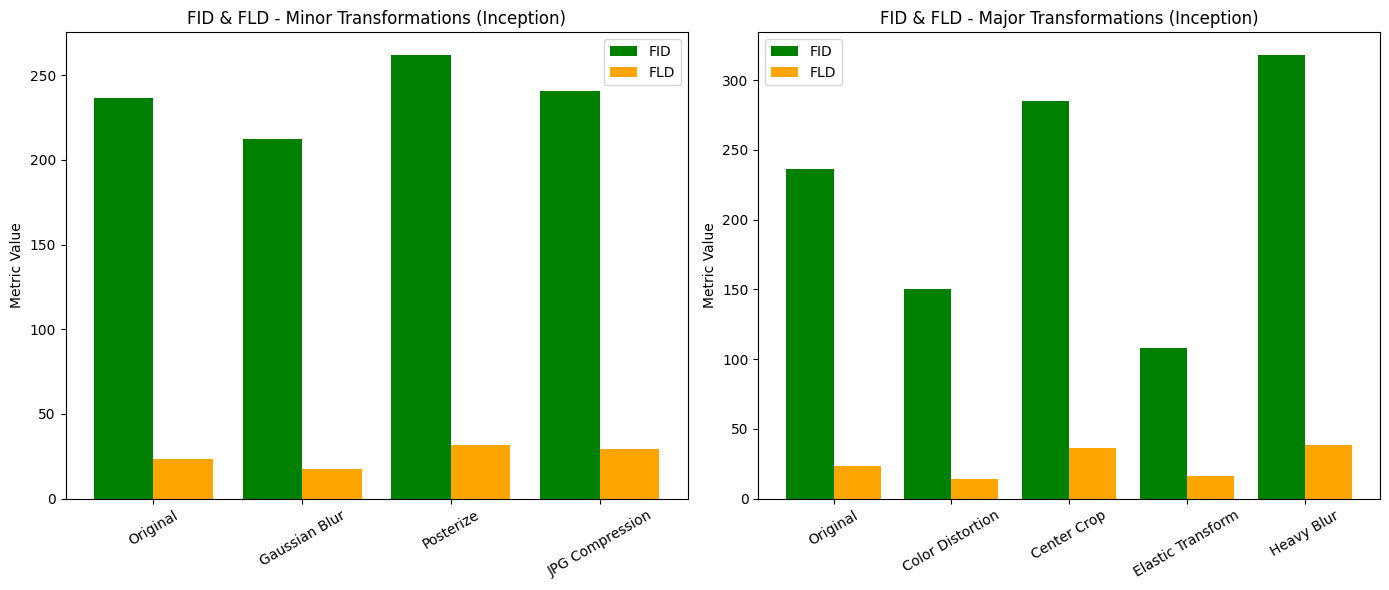

In [88]:
# Define the corrected FID and FLD scores for Inception feature space
fid_scores_I = {
    "Original": 236.35,
    "Gaussian Blur": 212.10, "Posterize": 262.26, "JPG Compression": 240.48,
    "Color Distortion": 150.08, "Center Crop": 285.04, "Elastic Transform": 108.28, "Heavy Blur": 318.27
}
fld_scores_I = {
    "Original": 23.24,
    "Gaussian Blur": 17.80, "Posterize": 31.46, "JPG Compression": 29.49,
    "Color Distortion": 14.41, "Center Crop": 36.20, "Elastic Transform": 16.16, "Heavy Blur": 38.66
}

# Define minor and major transformations
minor_feats_I = {"Gaussian Blur": None, "Posterize": None, "JPG Compression": None}
major_feats_I = {"Color Distortion": None, "Center Crop": None, "Elastic Transform": None, "Heavy Blur": None}

# Include the original results in the dictionaries for Inception features
fid_original_I = fid_scores_I["Original"]
fld_original_I = fld_scores_I["Original"]

# Separate minor and major transformation scores including the original
minor_fid_scores_I = {"Original": fid_original_I}
minor_fld_scores_I = {"Original": fld_original_I}
major_fid_scores_I = {"Original": fid_original_I}
major_fld_scores_I = {"Original": fld_original_I}

for name, value in fid_scores_I.items():
    if name in minor_feats_I.keys():
        minor_fid_scores_I[name] = value
    elif name in major_feats_I.keys():
        major_fid_scores_I[name] = value

for name, value in fld_scores_I.items():
    if name in minor_feats_I.keys():
        minor_fld_scores_I[name] = value
    elif name in major_feats_I.keys():
        major_fld_scores_I[name] = value

# Function to plot FID & FLD as adjacent bars for each transformation, including Original
def plot_fid_fld_adjacent_inception(minor_fid, minor_fld, major_fid, major_fld):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    width = 0.4  # Width of bars

    # Plot Minor Transformations
    minor_categories = list(minor_fid.keys())
    x_minor = np.arange(len(minor_categories))  # X locations for bars

    axes[0].bar(x_minor - width/2, minor_fid.values(), width, color='green', label="FID")
    axes[0].bar(x_minor + width/2, minor_fld.values(), width, color='orange', label="FLD")
    axes[0].set_title("FID & FLD - Minor Transformations (Inception)")
    axes[0].set_ylabel("Metric Value")
    axes[0].set_xticks(x_minor)
    axes[0].set_xticklabels(minor_categories, rotation=30)
    axes[0].legend()

    # Plot Major Transformations
    major_categories = list(major_fid.keys())
    x_major = np.arange(len(major_categories))  # X locations for bars

    axes[1].bar(x_major - width/2, major_fid.values(), width, color='green', label="FID")
    axes[1].bar(x_major + width/2, major_fld.values(), width, color='orange', label="FLD")
    axes[1].set_title("FID & FLD - Major Transformations (Inception)")
    axes[1].set_ylabel("Metric Value")
    axes[1].set_xticks(x_major)
    axes[1].set_xticklabels(major_categories, rotation=30)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot adjacent bars for FID & FLD using Inception features
plot_fid_fld_adjacent_inception(minor_fid_scores_I, minor_fld_scores_I, major_fid_scores_I, major_fld_scores_I)
